# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/0rep_0noiseLevel_MM_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/0rep_0noiseLevel_MM_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/0rep_0noiseLevel_MM_2ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/0rep_0noiseLevel_MM_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/0rep_0noiseLevel_MM_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/0rep_0noiseLevel_MM_2ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 2
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.312950        0.200245  0.048534  0.259149  0.059318   
       1.0    0.317689        0.197780  0.045460  0.191632  0.104224   
       1.5    0.319685        0.193850  0.042234  0.133763  0.118471   
       2.0    0.320377        0.189189  0.039390  0.092967  0.109573   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.195011  0.006108  0.038680  0.058472  0.001079  
       1.0   0.201154  0.007591  0.033170  0.073280  0.003737  
       1.5   0.217767  0.010131  0.025864  0.093370  0.007880  
       2.0   0.228526  0.013479  0.019942  0.116984  0.013686

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.312950        0.200245  0.048534  0.259149  0.059318   
       1.0    0.317689        0.197780  0.045460  0.191632  0.104224   
       1.5    0.319685        0.193850  0.042234  0.133763  0.118471   
       2.0    0.320377        0.189189  0.039390  0.092967  0.109573   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.195011  0.006108  0.038680  0.058472  0.001079  
       1.0   0.201154  0.007591  0.033170  0.073280  0.003737  
       1.5   0.217767  0.010131  0.025864  0.093370  0.007880  
       2.0   0.228526  0.013479  0.019942  0.116984  0.013686

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.312950        0.200245  0.048534  0.259149  0.059318   
       1.0    0.317689        0.197780  0.045460  0.191632  0.104224   
       1.5    0.319685        0.193850  0.042234  0.133763  0.118471   
       2.0    0.320377        0.189189  0.039390  0.092967  0.109573   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.195011  0.006108  0.038680  0.058472  0.001079  
       1.0   0.201154  0.007591  0.033170  0.073280  0.003737  
       1.5   0.217767  0.010131  0.025864  0.093370  0.007880  
       2.0   0.228526  0.013479  0.019942  0.116984  0.013686

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.5    0.295498        0.200425  0.060938  0.195920  0.112245   
         1.0    0.272992        0.193767  0.078634  0.079861  0.171375   
         1.5    0.247259        0.183511  0.094572  0.031327  0.148031   
         2.0    0.222240        0.171758  0.106426  0.018138  0.106571   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
         0.5   0.181601  0.014419  0.038643  0.064898  0.000488  
         1.0   0.173169  0.020703  0.032371  0.100826  0.001928  
         1.5   0.154712  0.027644  0.028134  0.149235  0.004613  
         2.0   0.109090  0.029339  0.027014  0.204377  0.008835

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.5   5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         1.0   6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   
         1.5   6.303323e+06  5.167157e+06  546287.047997  3.570656e+06   
         2.0   6.425365e+06  5.499584e+06  591328.783707  3.865639e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.5   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         1.5   1.118956e+06  6.520026e+06  3.935836e+06  9.528769e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.341080  
         0.5      286614.273964  
         1.0      398139.231561  
         1.5      457478.291179  
         2.0      494315.467226

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


,,Missing Values,% of Total Values


,,Missing Values,% of Total Values


# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


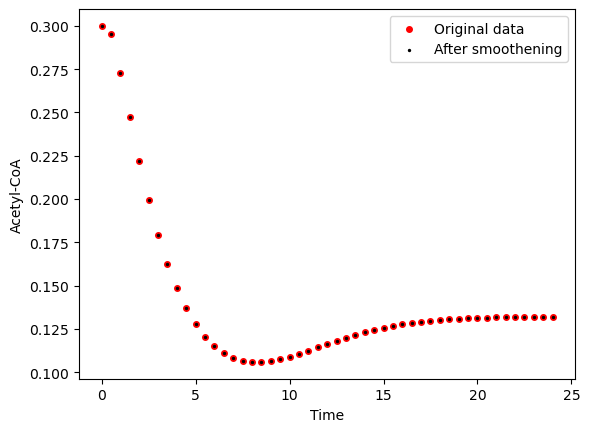

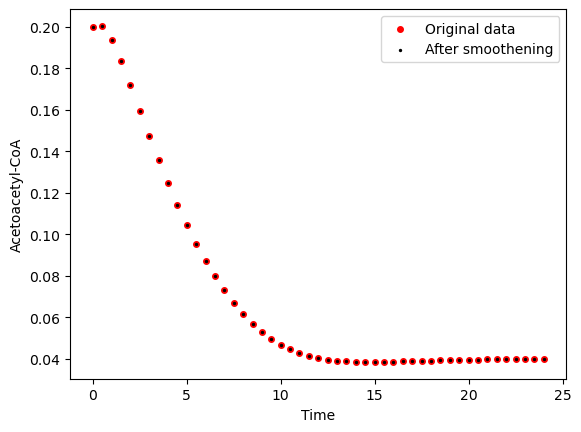

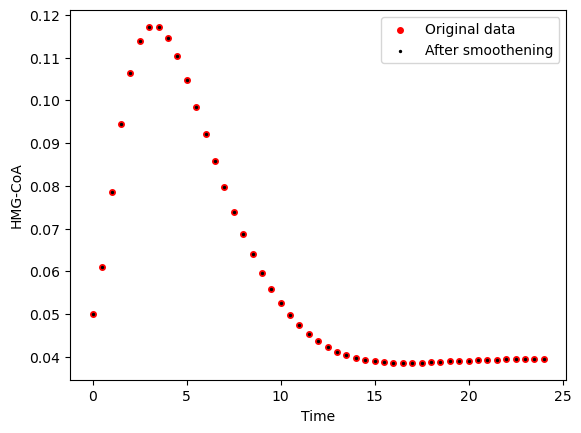

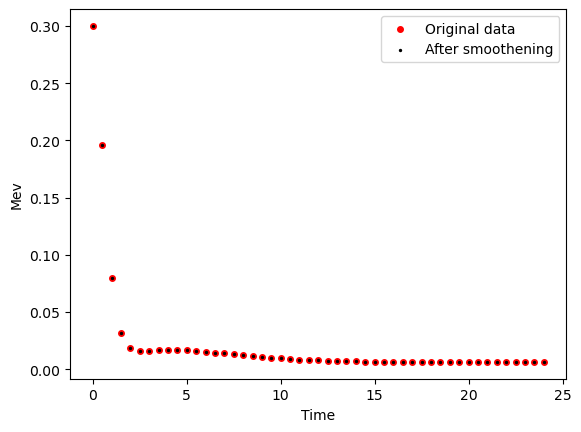

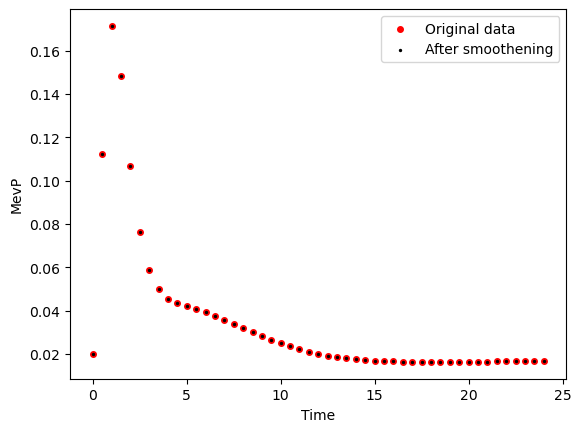

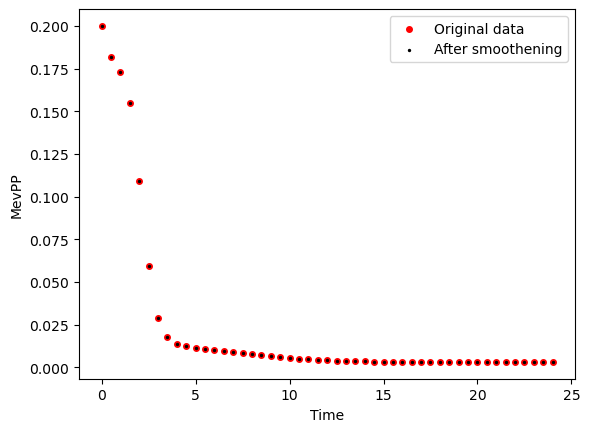

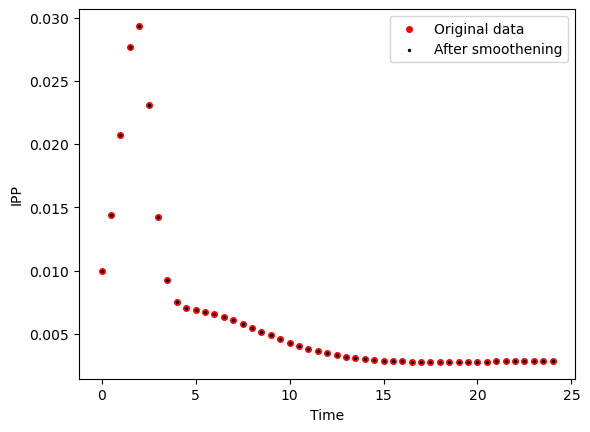

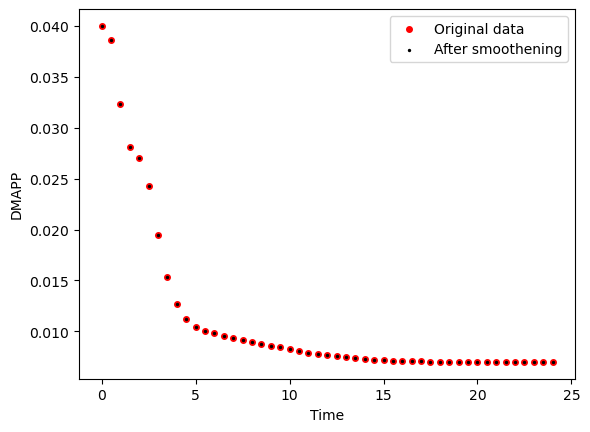

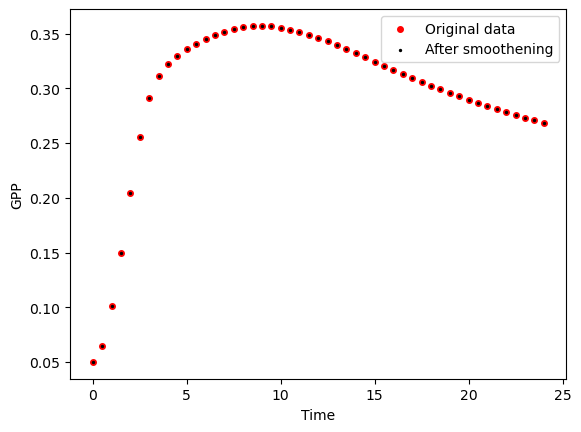

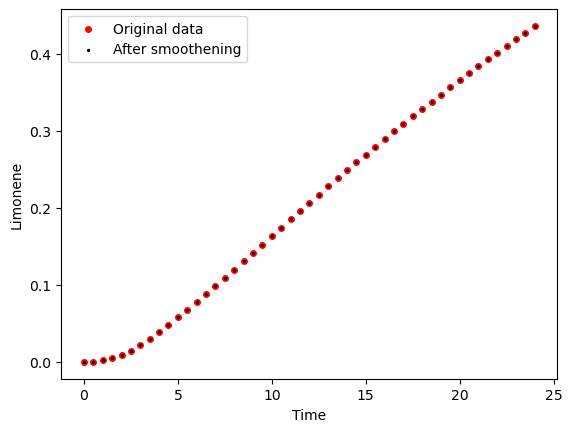

Strain Strain 2


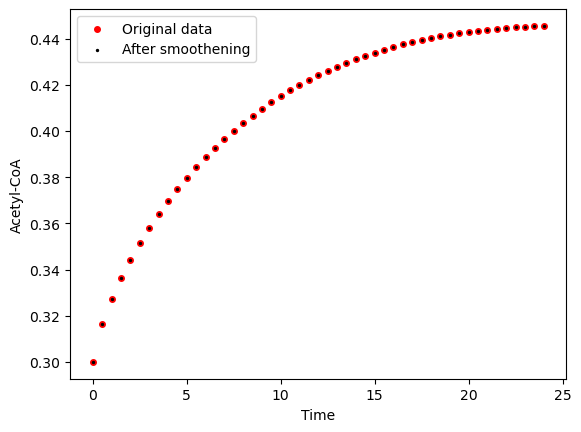

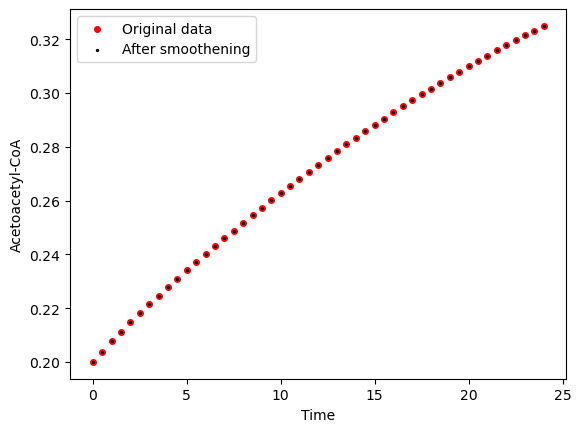

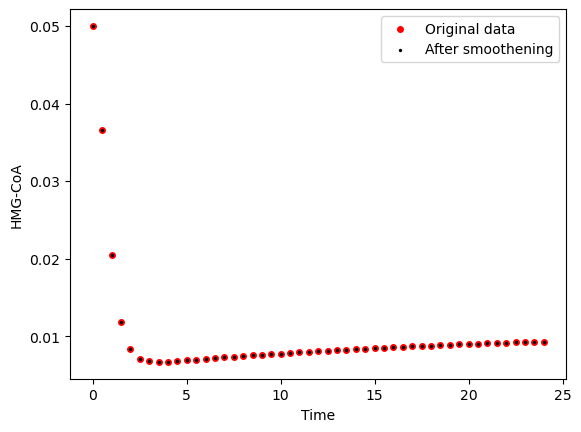

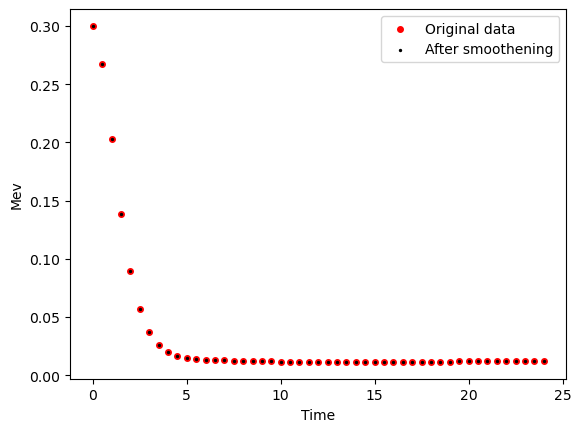

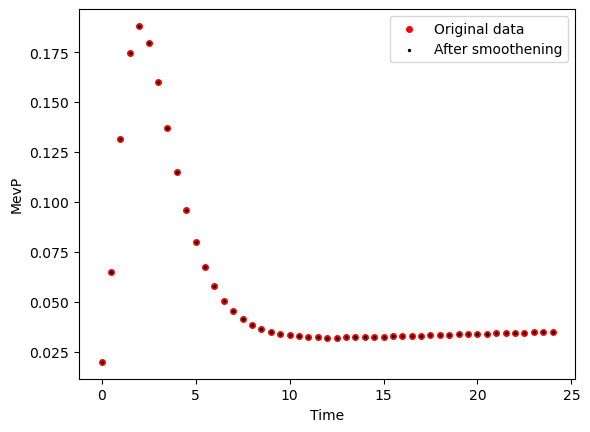

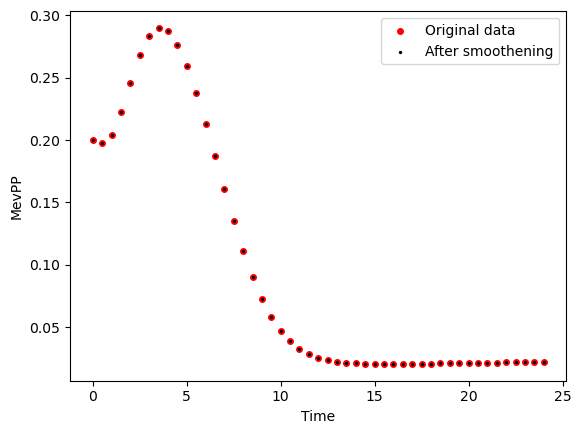

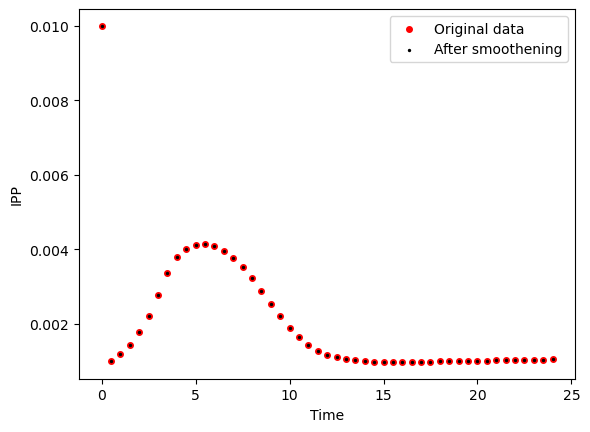

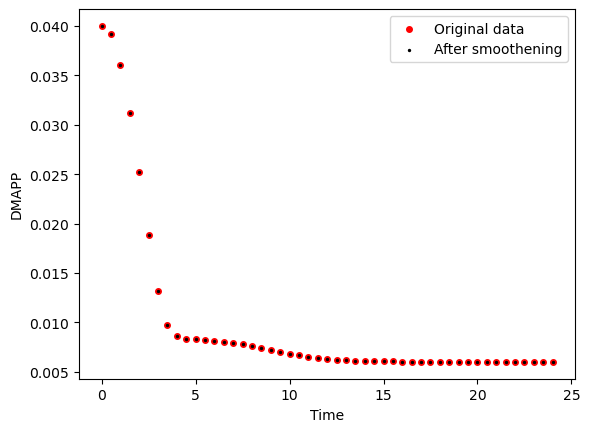

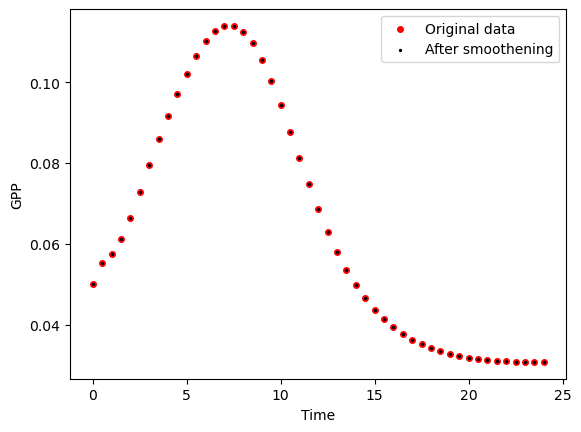

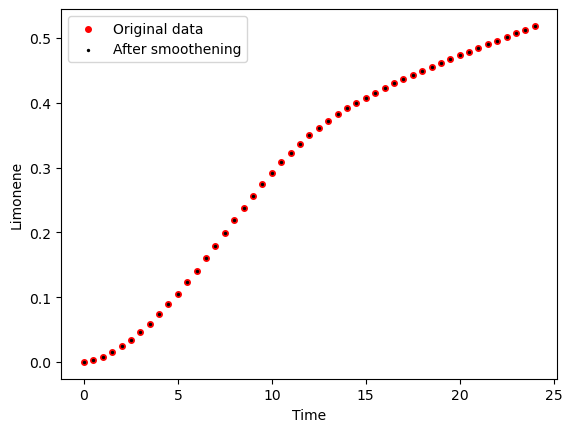

Strain Strain 3


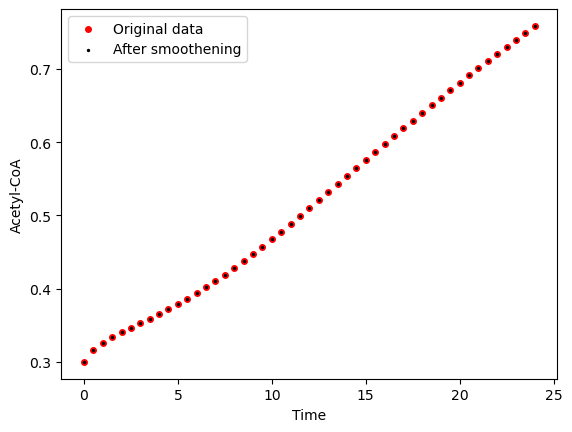

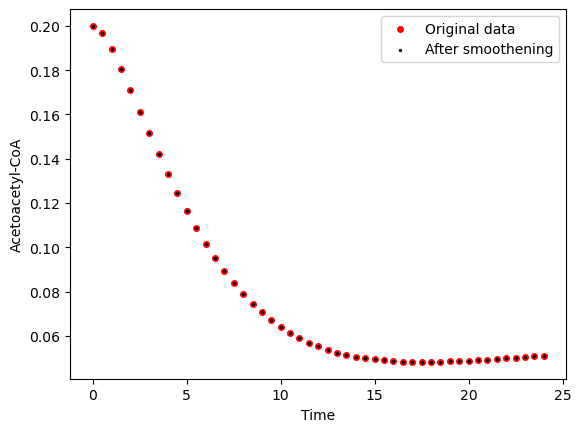

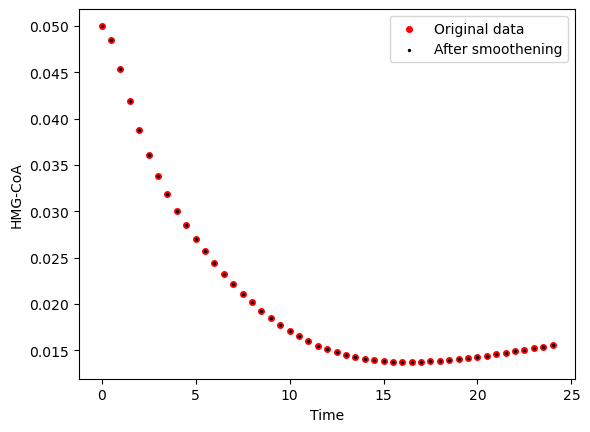

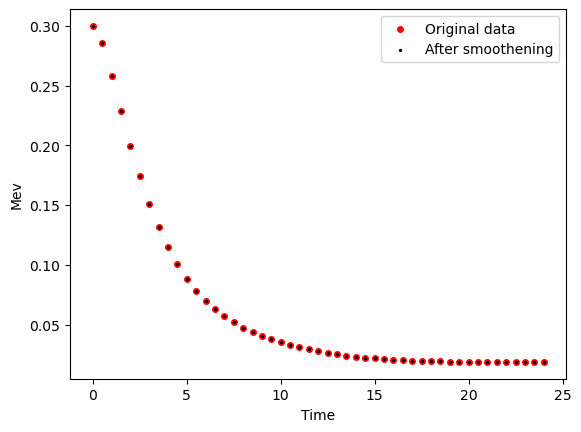

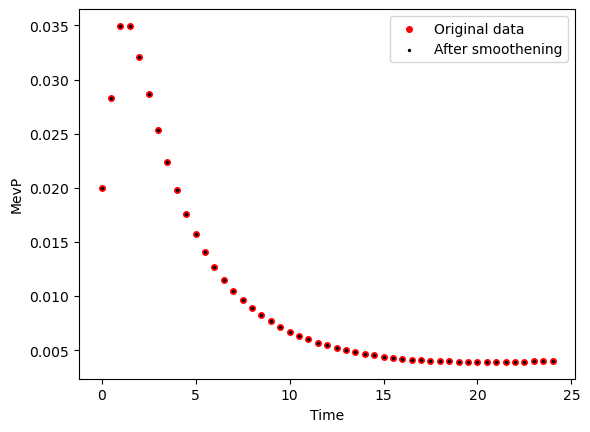

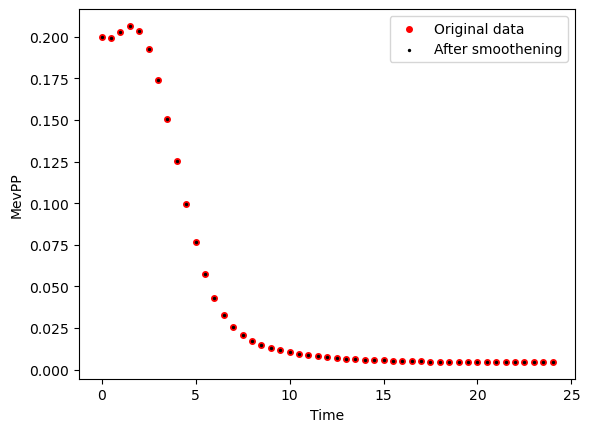

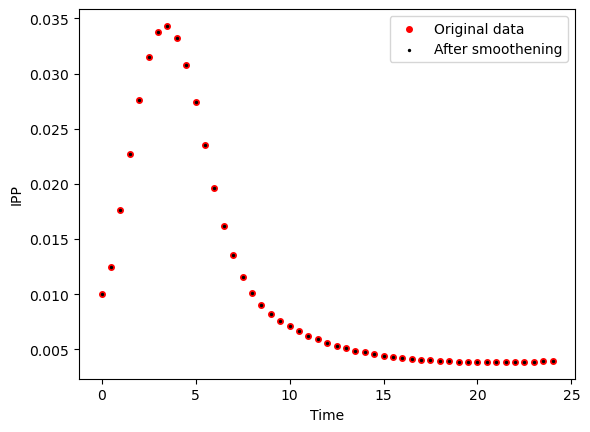

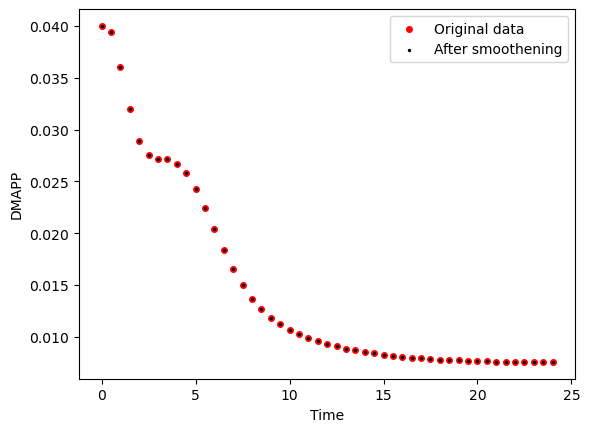

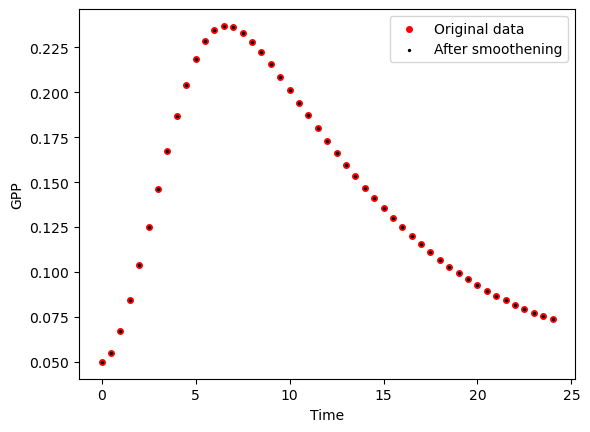

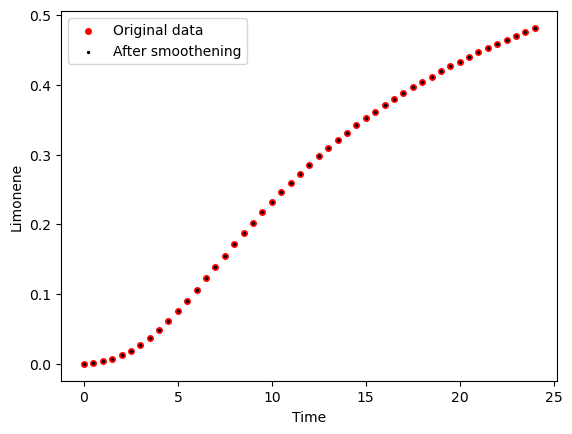

Strain WT


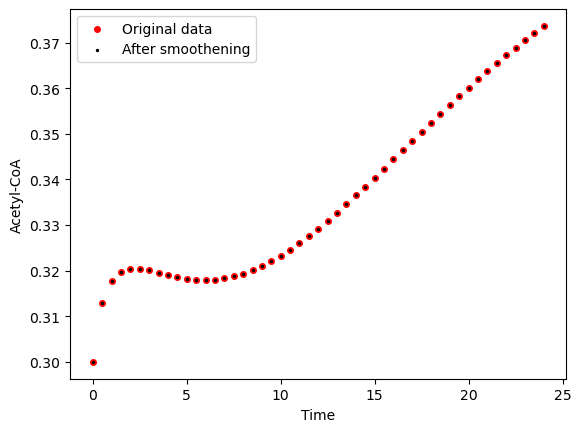

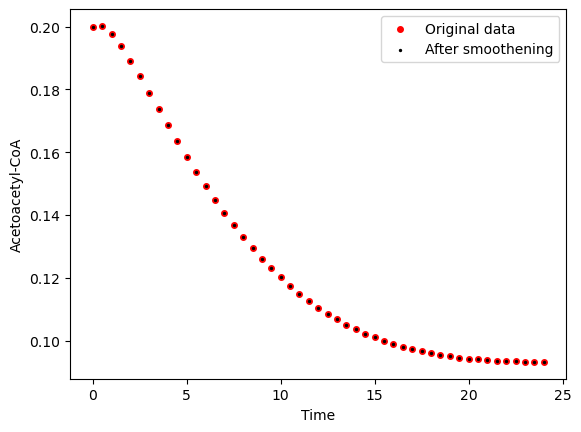

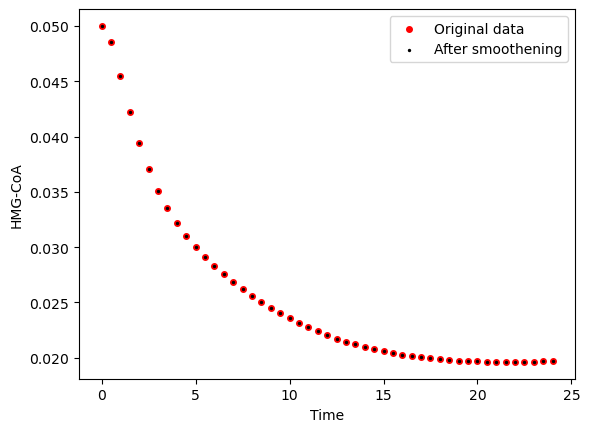

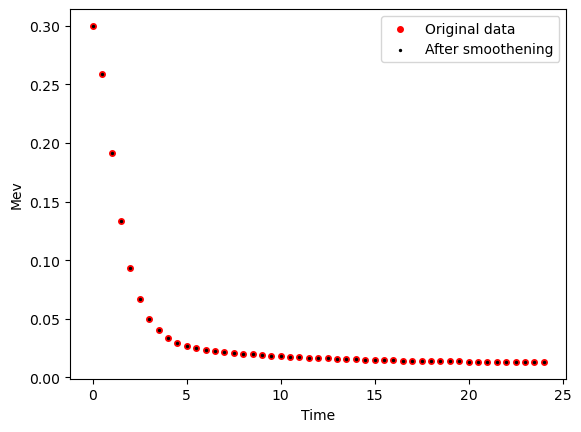

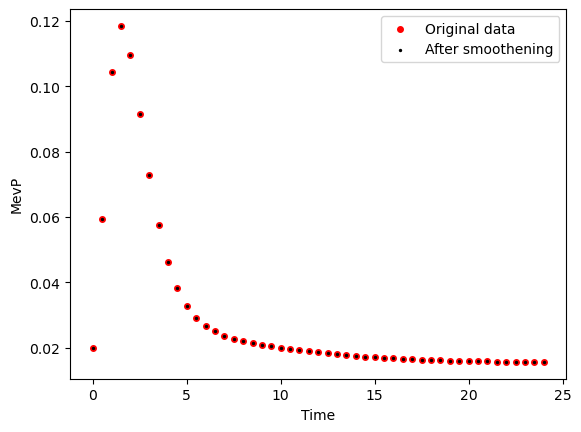

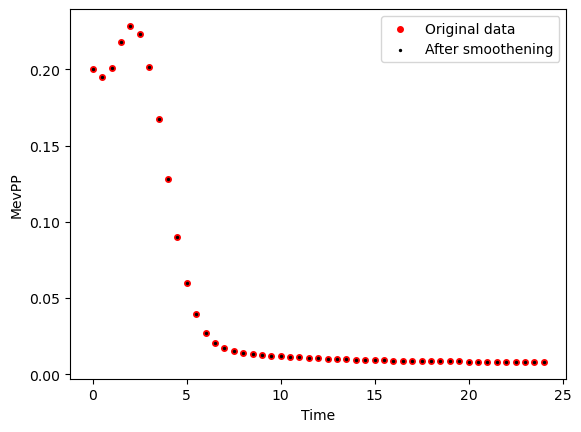

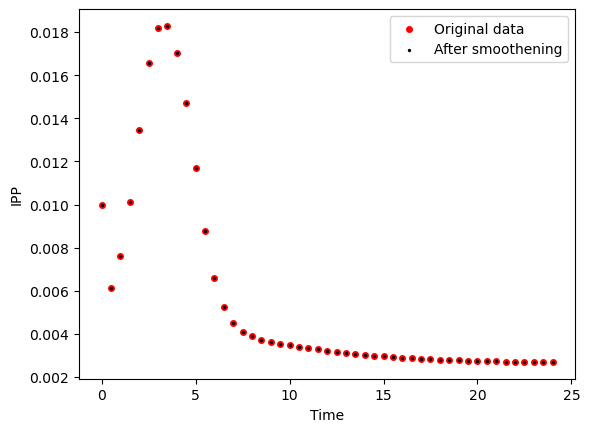

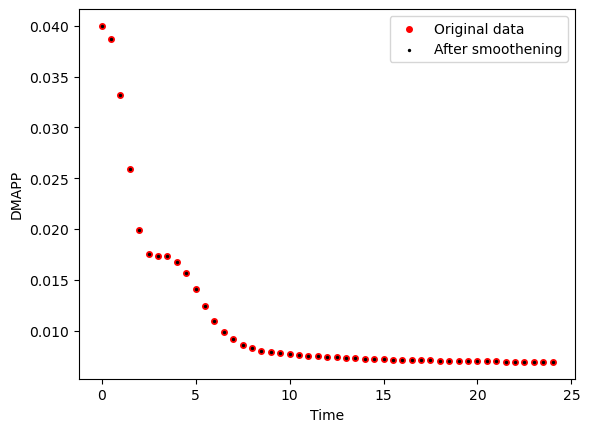

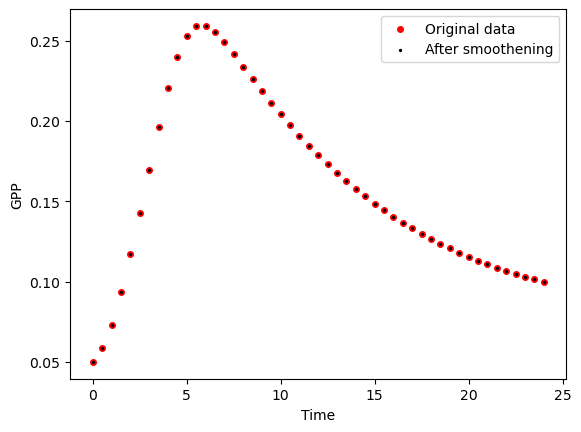

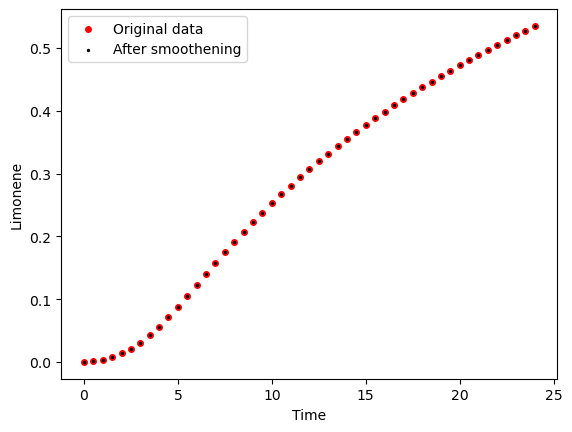

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


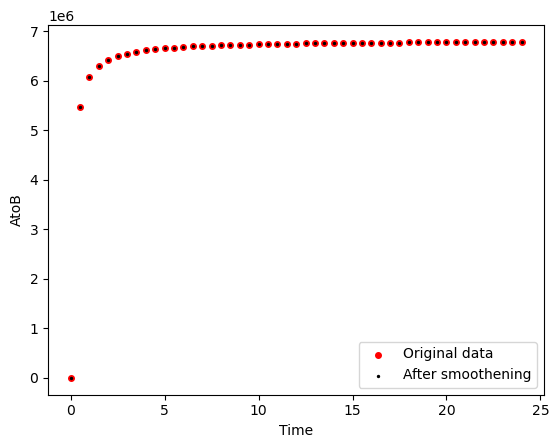

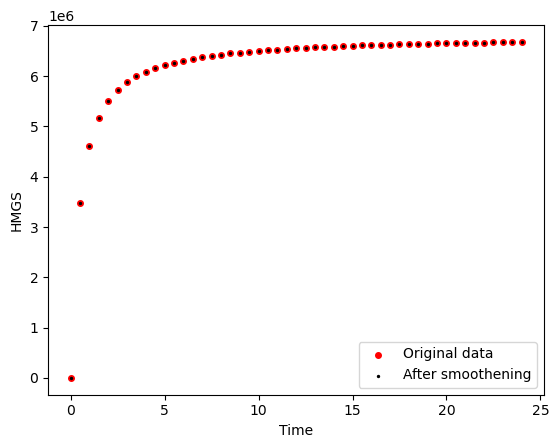

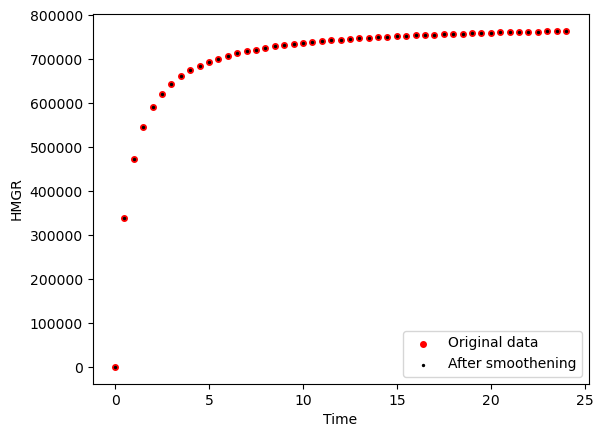

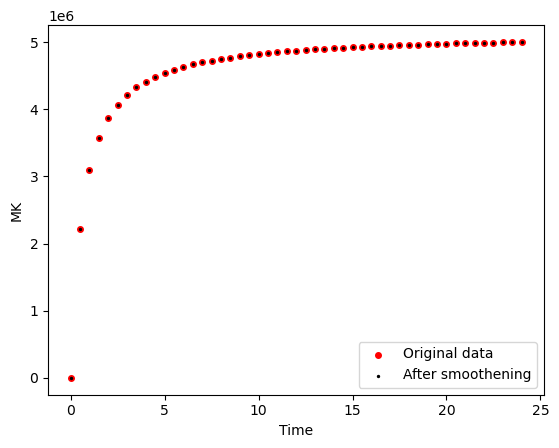

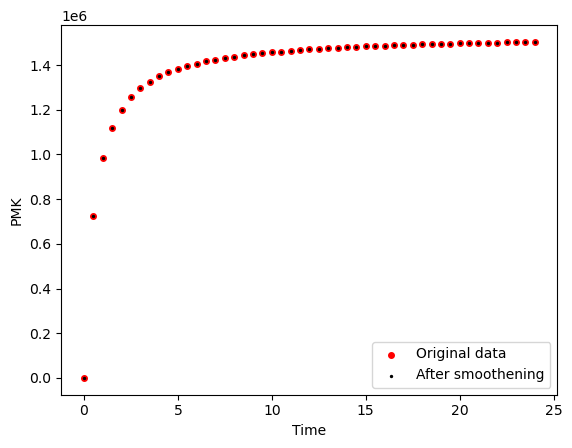

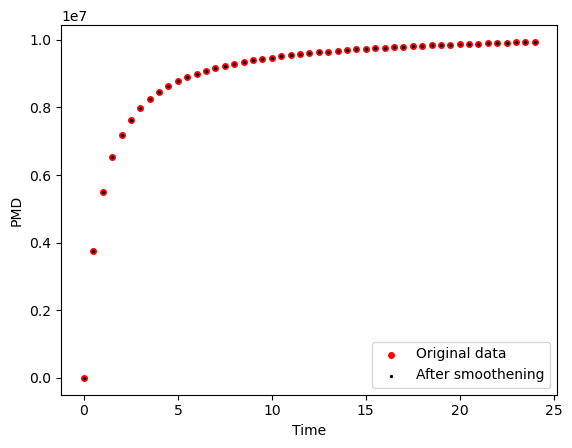

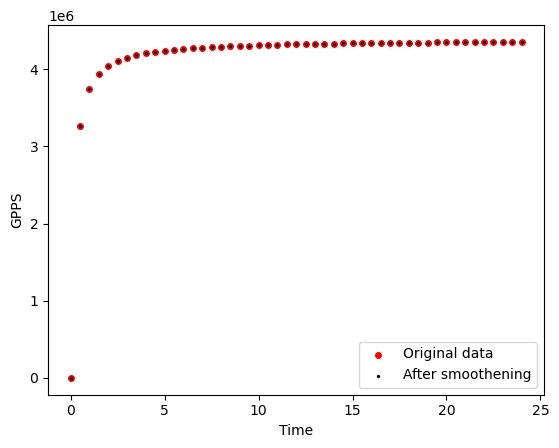

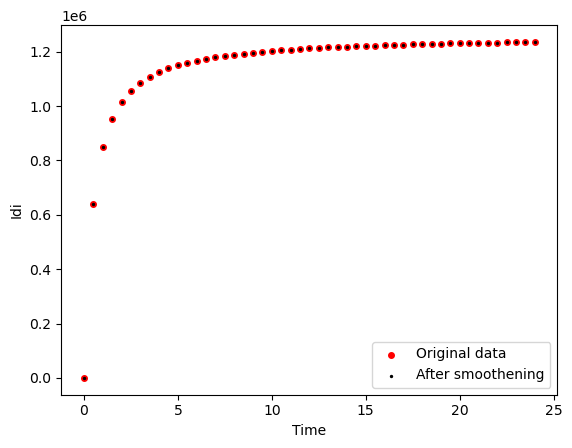

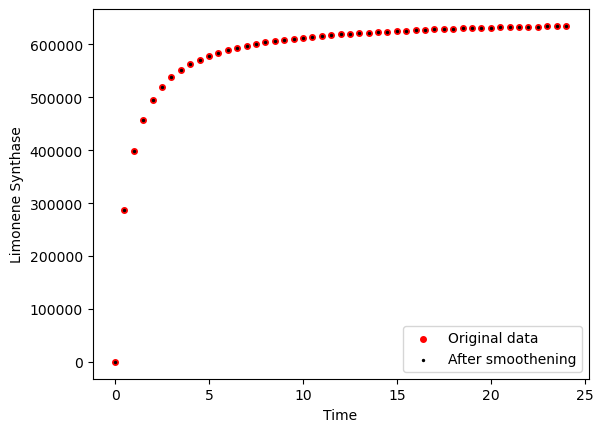

Strain Strain 2


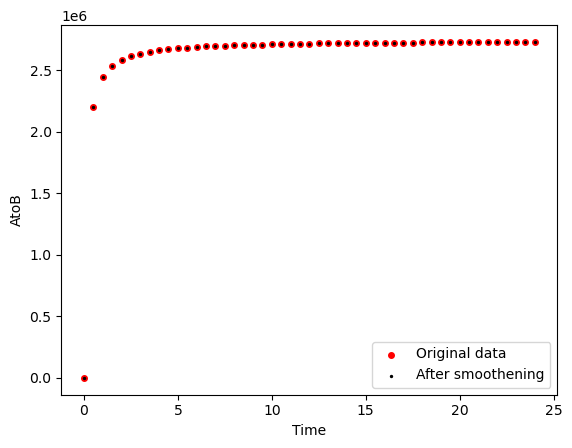

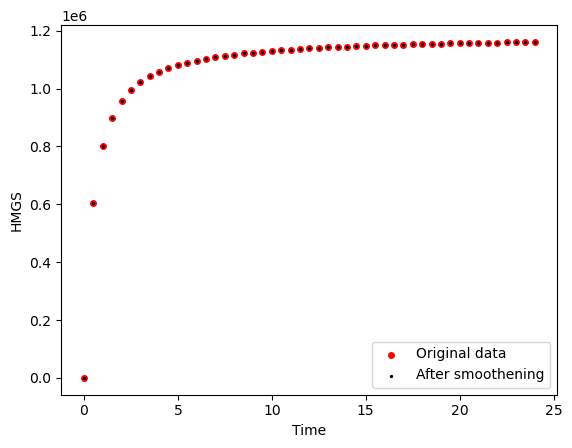

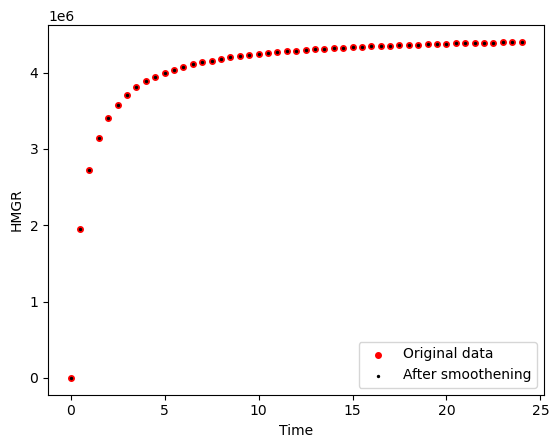

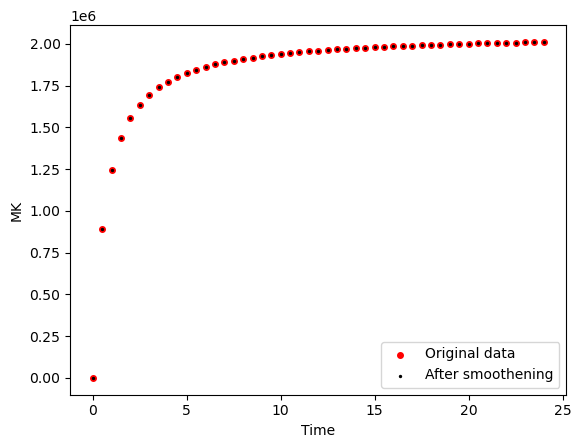

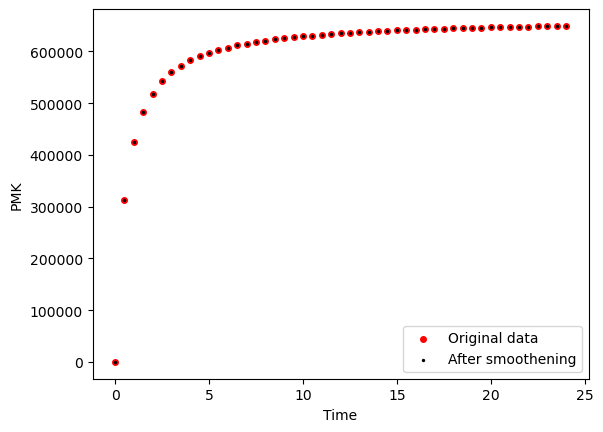

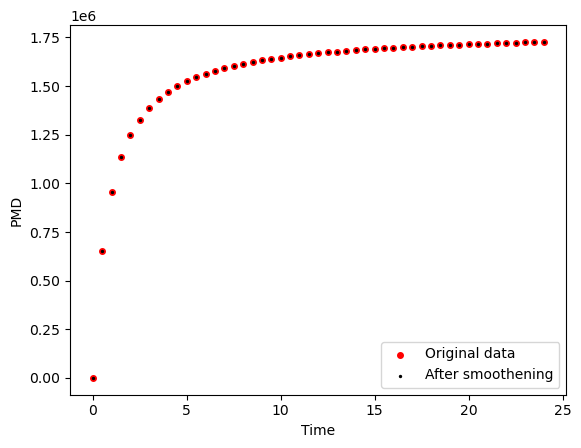

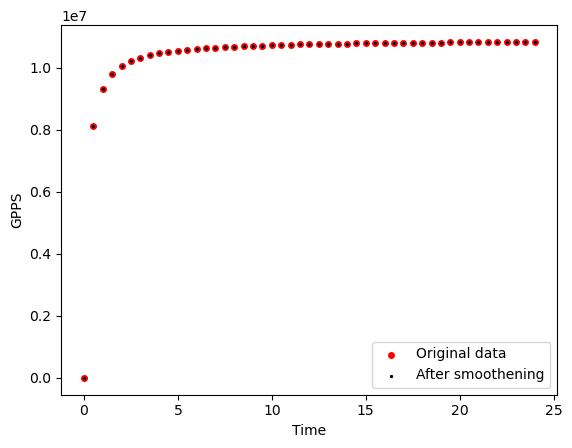

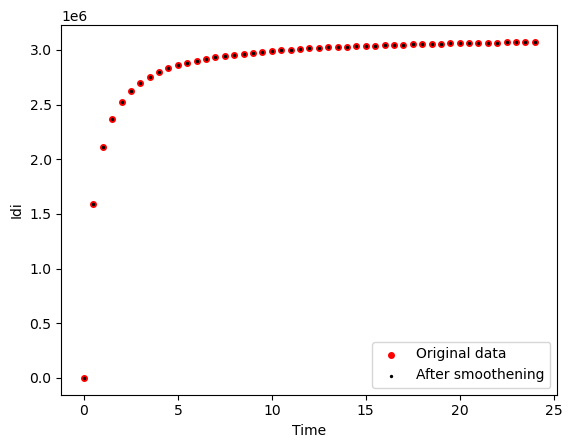

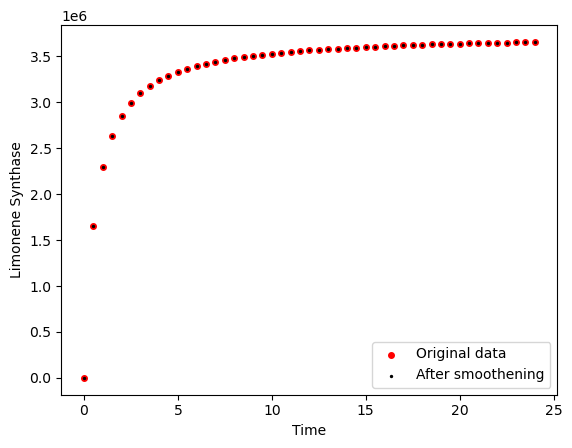

Strain Strain 3


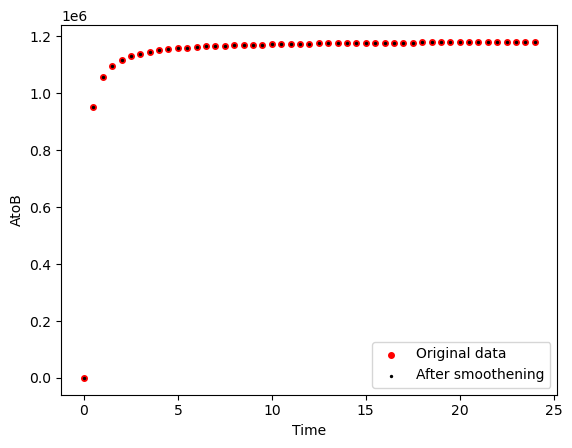

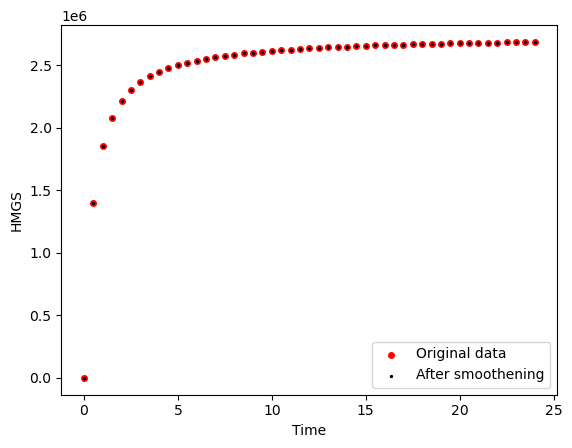

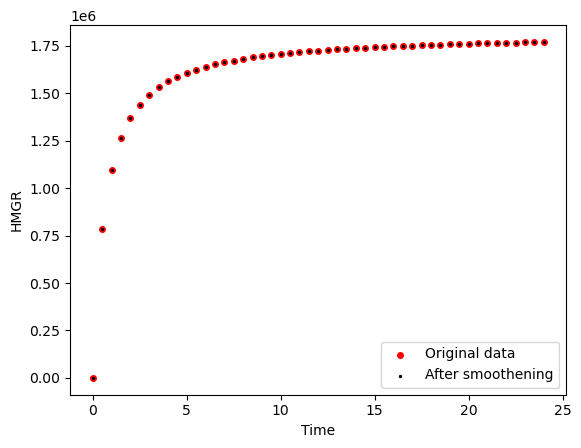

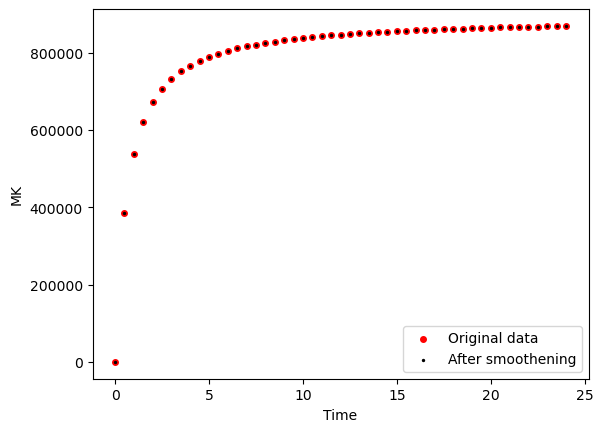

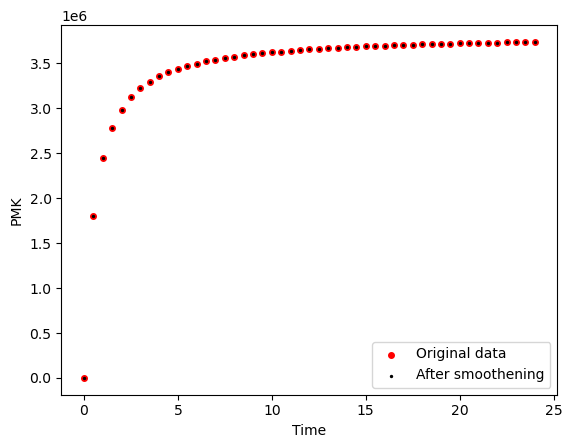

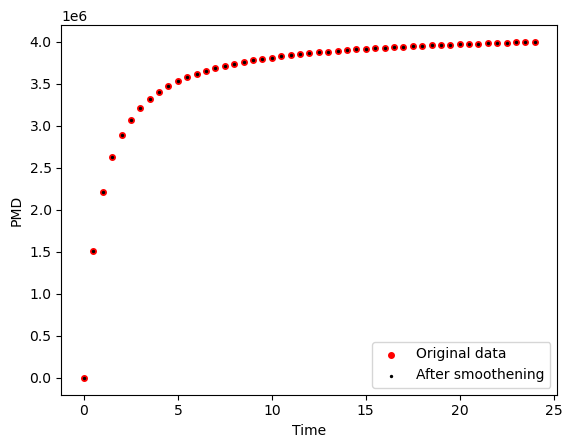

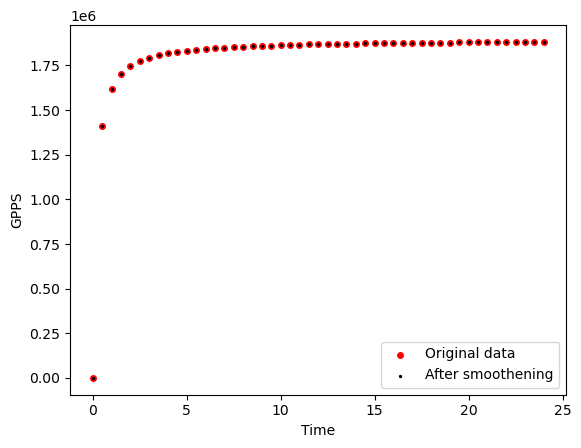

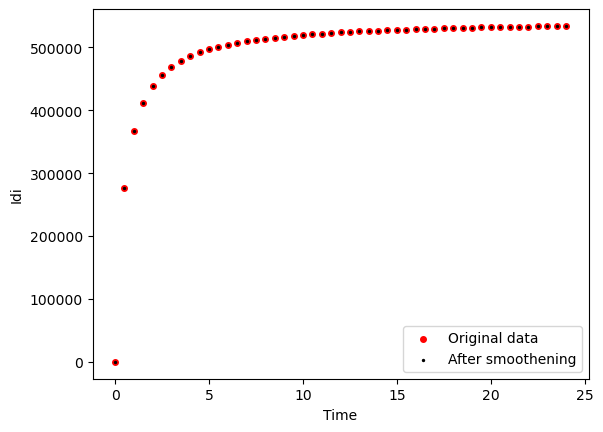

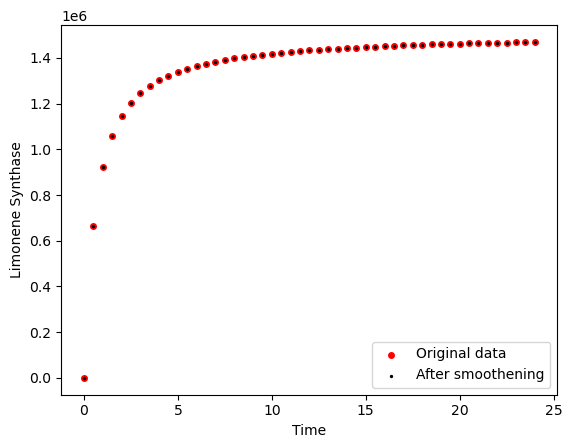

Strain WT


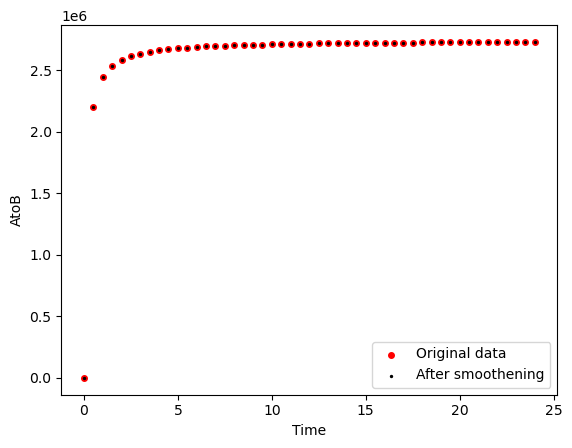

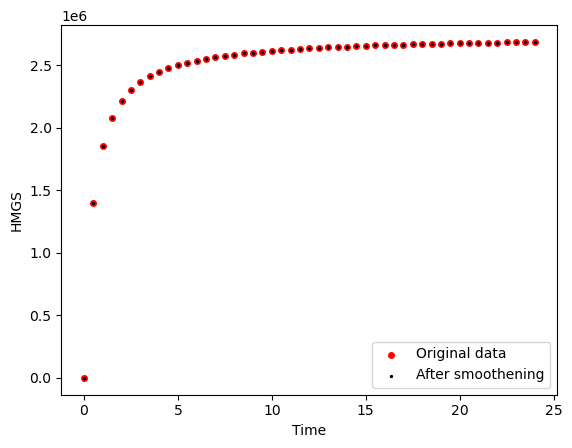

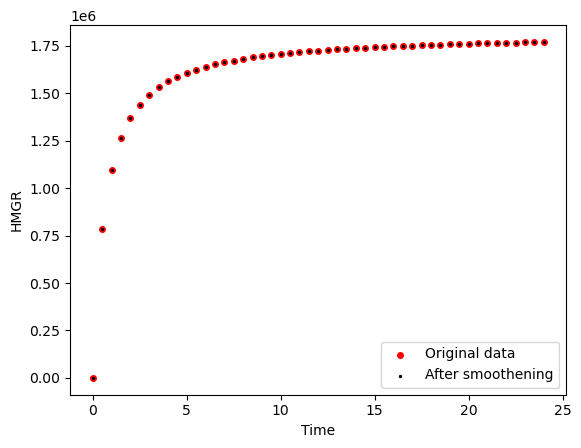

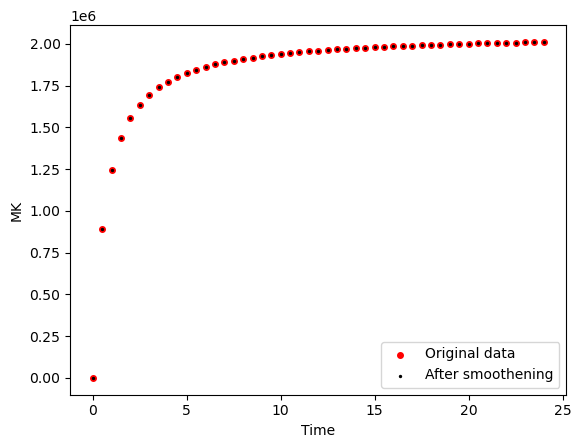

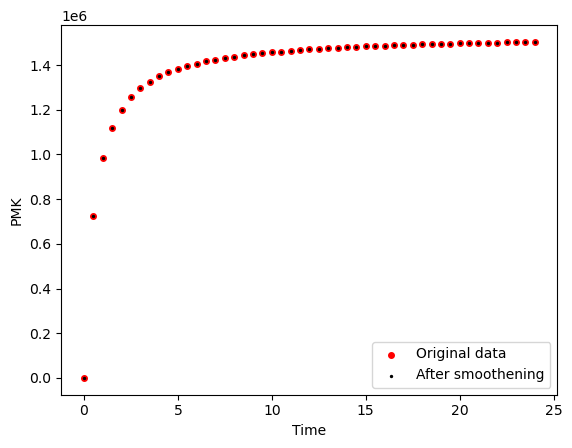

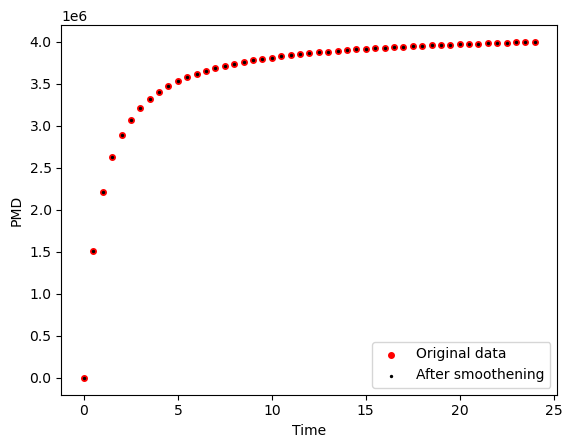

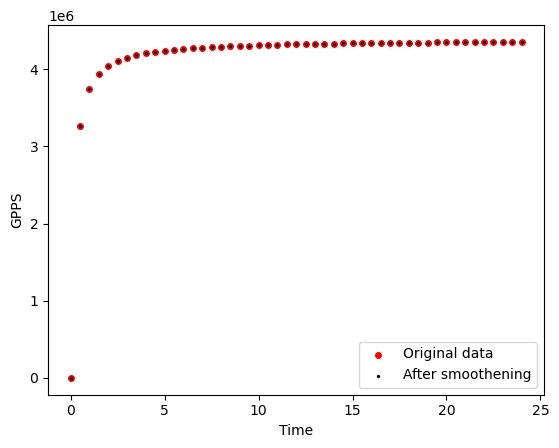

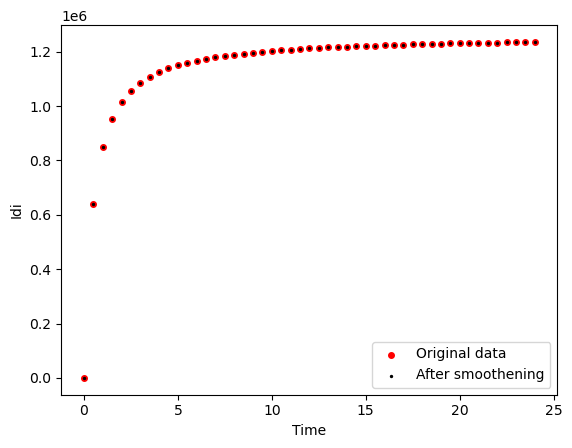

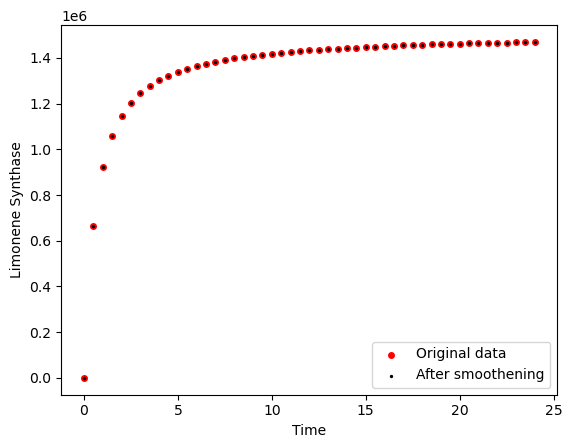

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative

df_allSmooth=estimate_state_derivative(df_allSmooth,5,3)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.5    0.295498        0.200425  0.060938  0.195920  0.112245   
         1.0    0.272992        0.193767  0.078634  0.079861  0.171375   
         1.5    0.247259        0.183511  0.094572  0.031327  0.148031   
         2.0    0.222240        0.171758  0.106426  0.018138  0.106571   
...                  ...             ...       ...       ...       ...   
WT       22.0   0.367253        0.093487  0.019629  0.013205  0.015704   
         22.5   0.368929        0.093382  0.019637  0.013167  0.015678   
         23.0   0.370558        0.093309  0.019650  0.013135  0.015658   
         23.5   0.372140        0.093264  0.019669  0.013108  0.015644   
         24.0   0.373674        0.093246  0.019692  0.013086  0.015634   

                                                                 ...  \
                  MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                    ...   
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.5   0.181601  0.014419  0.038643  0.064898  0.000488  ...   
         1.0   0.173169  0.020703  0.032371  0.100826  0.001928  ...   
         1.5   0.154712  0.027644  0.028134  0.149235  0.004613  ...   
         2.0   0.109090  0.029339  0.027014  0.204377  0.008835  ...   
...                 ...       ...       ...       ...       ...  ...   
WT       22.0  0.008120  0.002712  0.006941  0.106707  0.504953  ...   
         22.5  0.008096  0.002707  0.006934  0.104854  0.512710  ...   
         23.0  0.008076  0.002704  0.006927  0.103119  0.520339  ...   
         23.5  0.008061  0.002701  0.006921  0.101497  0.527850  ...   
         24.0  0.008049  0.002700  0.006916  0.099981  0.535250  ...   

              derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0     0.011369        0.009301  0.013716 -0.220295  0.263219   
         0.5    -0.029353       -0.007065  0.029999 -0.220049  0.140752   
         1.0    -0.051358       -0.017845  0.035441 -0.172480  0.033286   
         1.5    -0.051664       -0.022533  0.028240 -0.052298 -0.080370   
         2.0    -0.048146       -0.024229  0.019254 -0.009927 -0.077197   
...                   ...             ...       ...       ...       ...   
WT       22.0    0.003397       -0.000246  0.000010 -0.000083 -0.000058   
         22.5    0.003306       -0.000178  0.000022 -0.000070 -0.000045   
         23.0    0.003212       -0.000116  0.000032 -0.000059 -0.000034   
         23.5    0.003116       -0.000061  0.000042 -0.000048 -0.000023   
         24.0    0.003018       -0.000013  0.000050 -0.000039 -0.000014   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.058123  0.002925  0.002783  0.005002  0.000218  
         0.5  -0.020846  0.012224 -0.008549  0.053008  0.001831  
         1.0  -0.020701  0.014411 -0.011848  0.086719  0.004028  
         1.5  -0.065010  0.010076 -0.004743  0.106262  0.006840  
         2.0  -0.103538 -0.005049 -0.003032  0.110230  0.010109  
...                 ...       ...       ...       ...       ...  
WT       22.0 -0.000053 -0.000010 -0.000016 -0.003828  0.015645  
         22.5 -0.000044 -0.000008 -0.000014 -0.003586  0.015383  
         23.0 -0.000035 -0.000006 -0.000012 -0.003355  0.015138  
         23.5 -0.000027 -0.000004 -0.000011 -0.003136  0.014908  
         24.0 -0.000020 -0.000002 -0.000009 -0.002928  0.014694

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

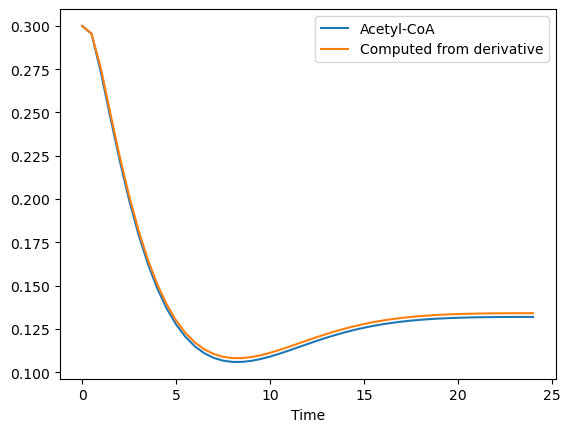

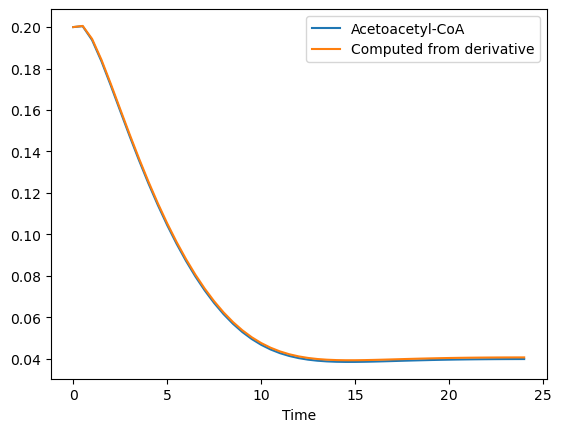

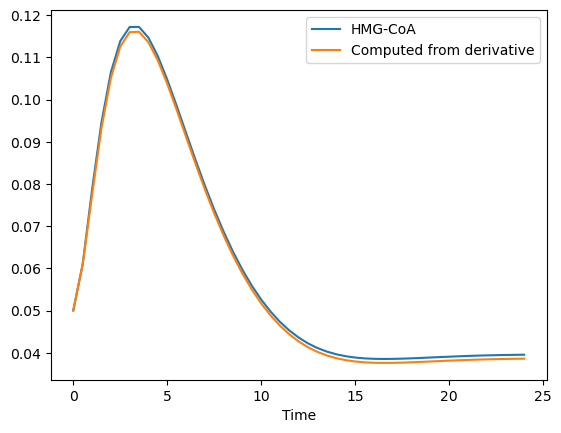

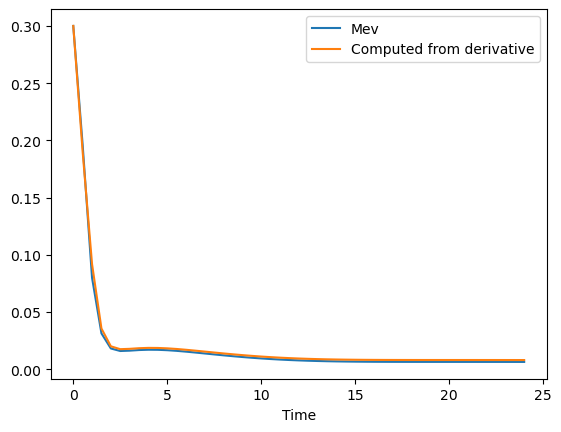

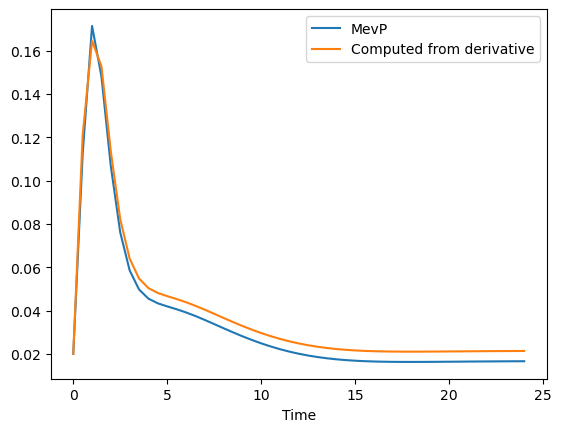

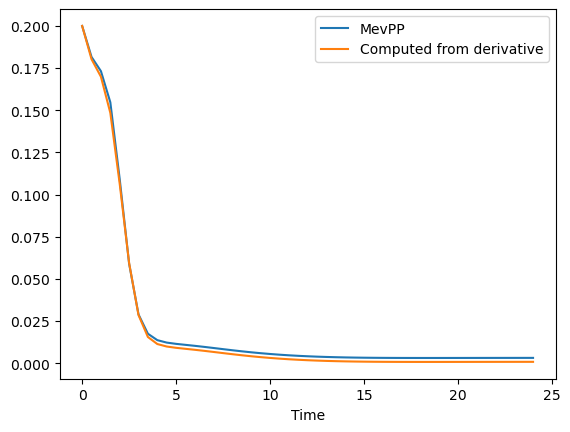

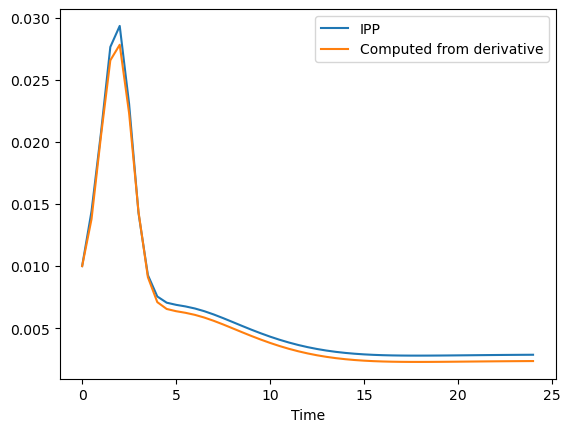

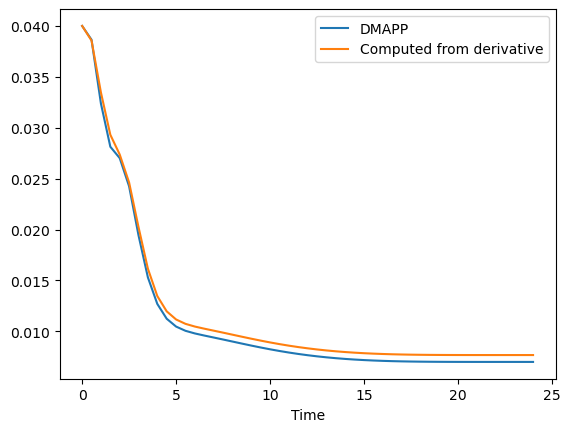

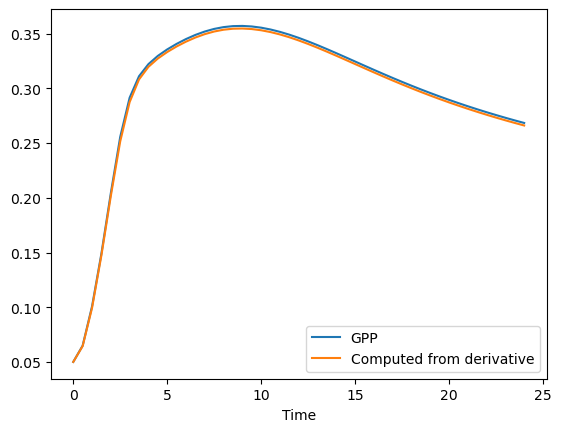

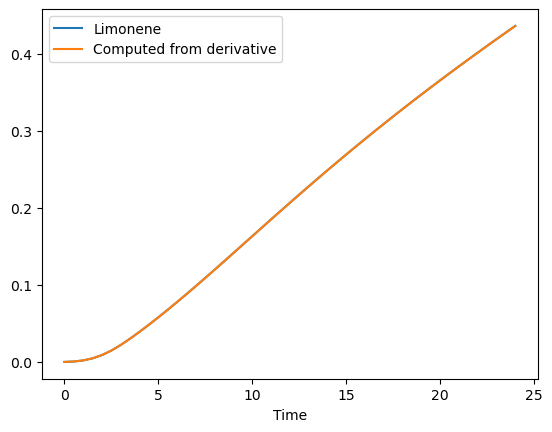

'Time profile from derivative vs. actual profile for Strain 2'

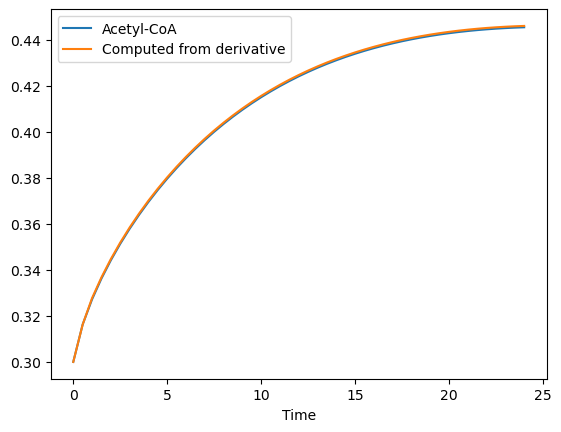

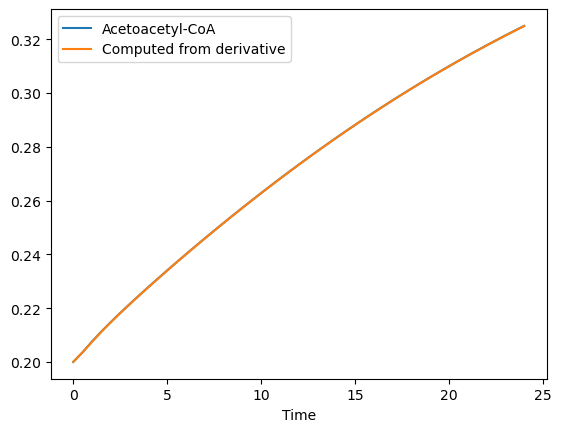

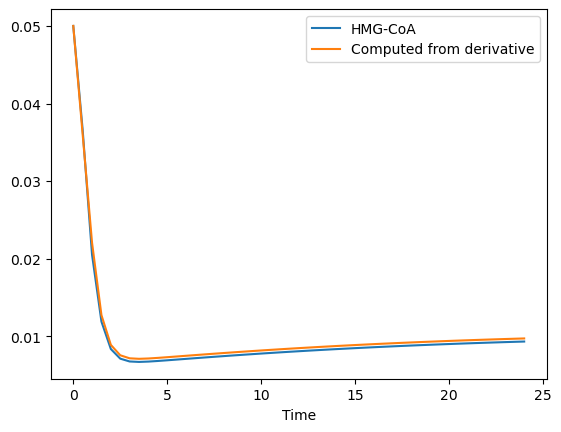

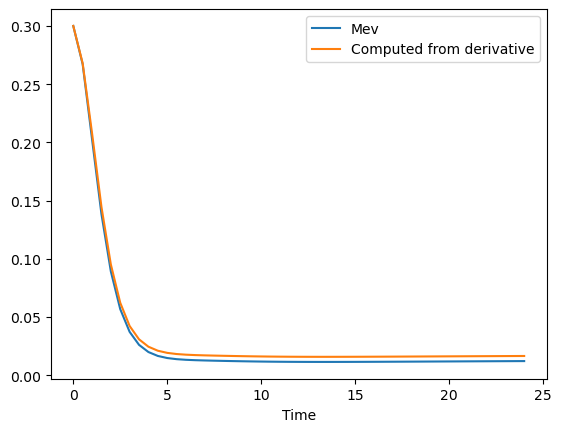

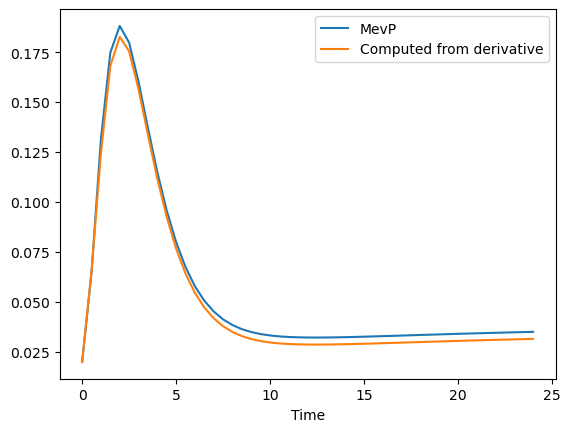

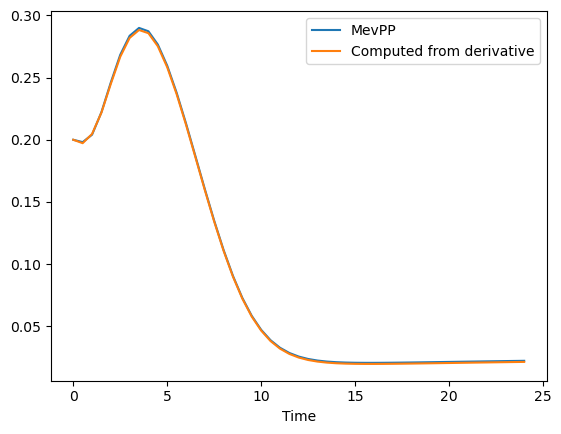

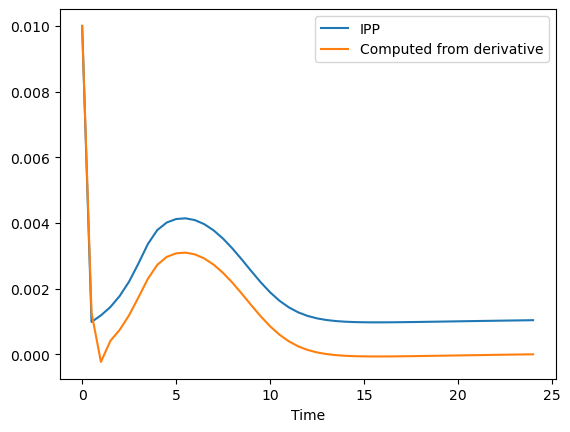

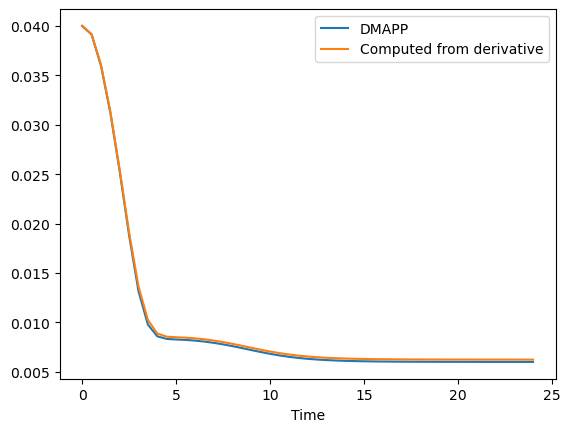

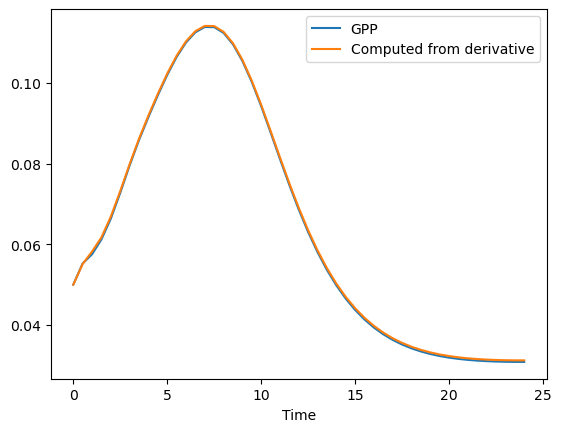

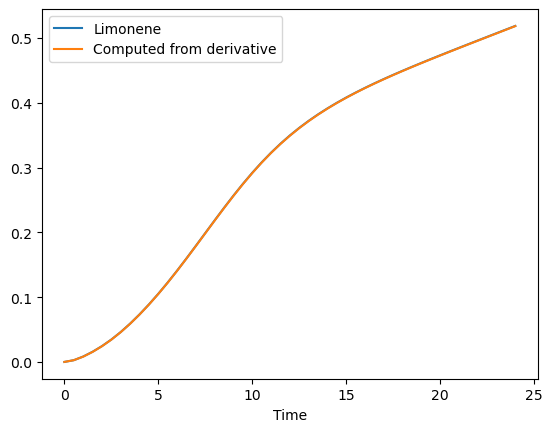

'Time profile from derivative vs. actual profile for Strain 3'

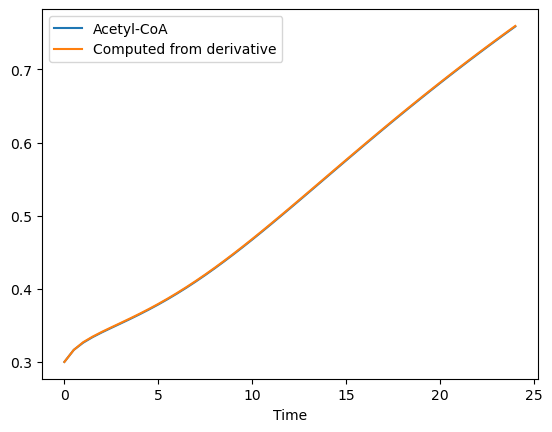

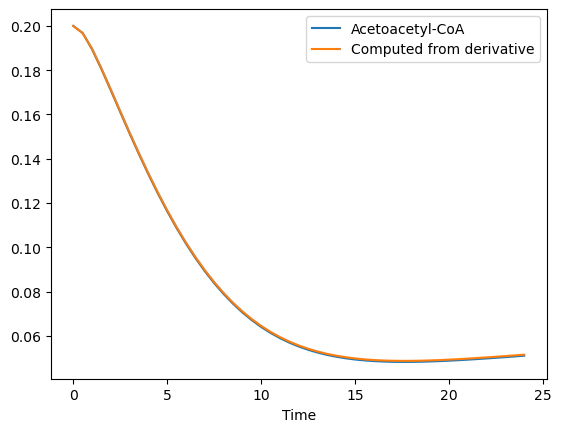

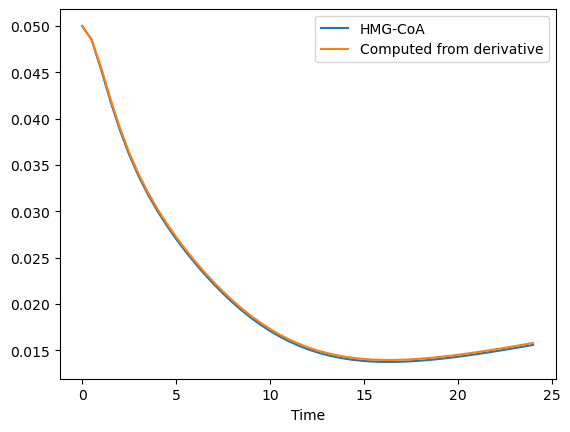

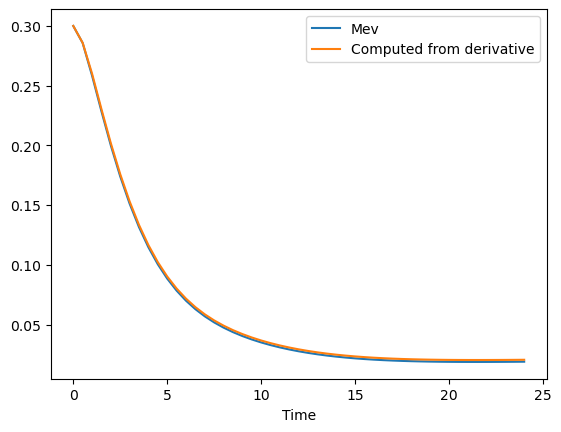

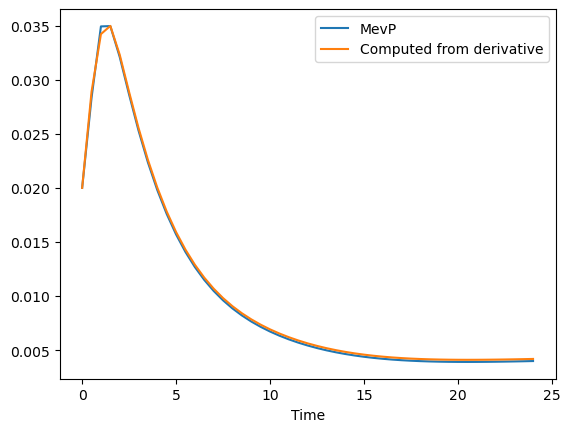

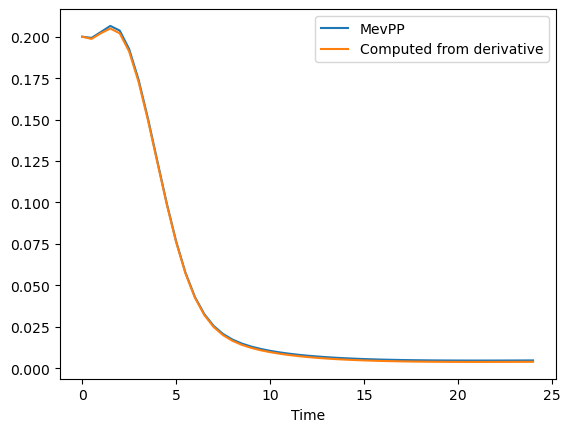

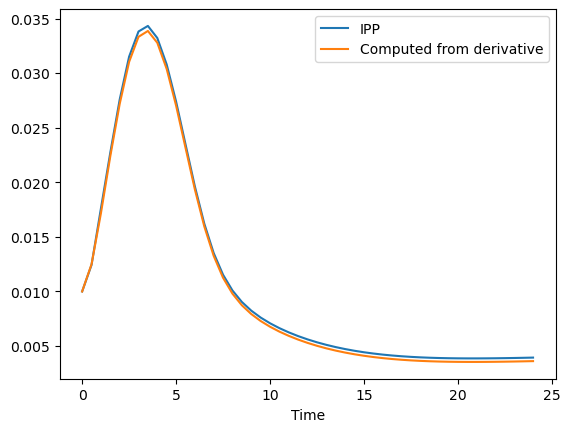

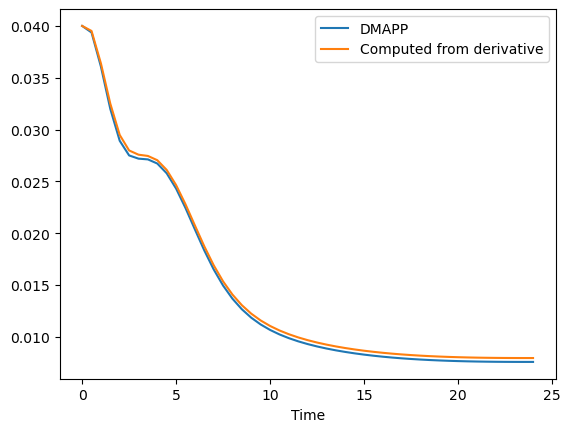

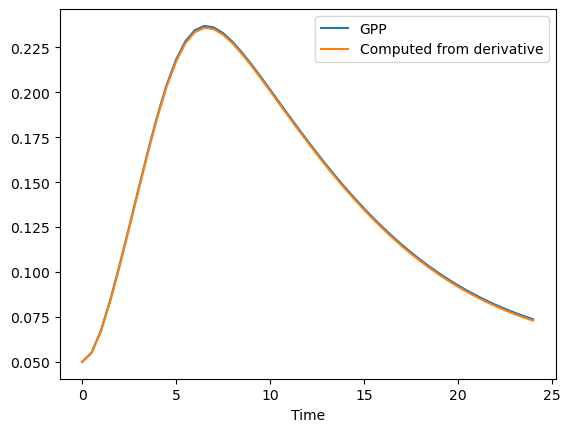

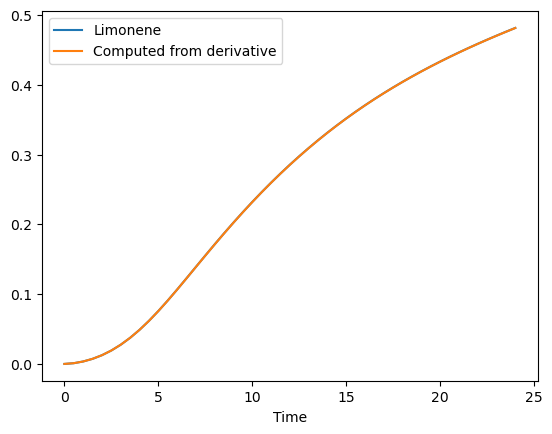

'Time profile from derivative vs. actual profile for WT'

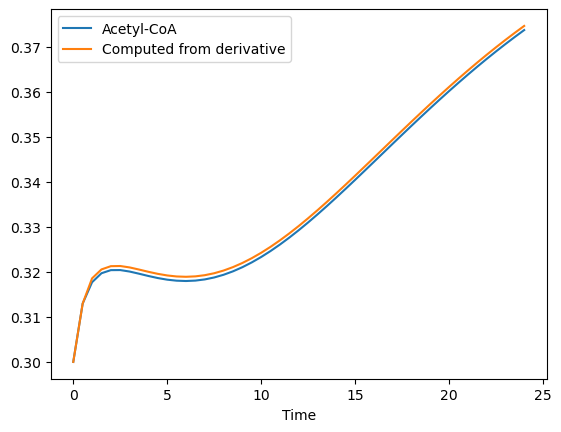

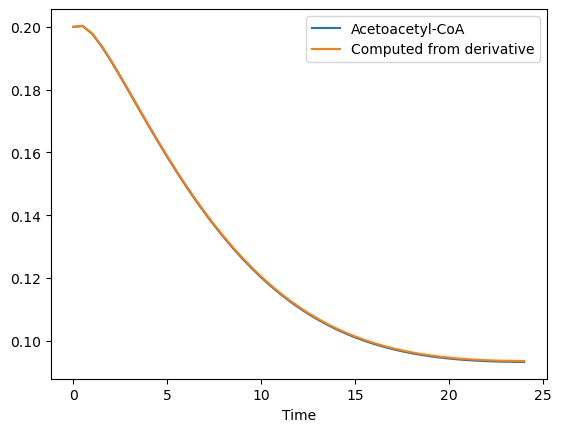

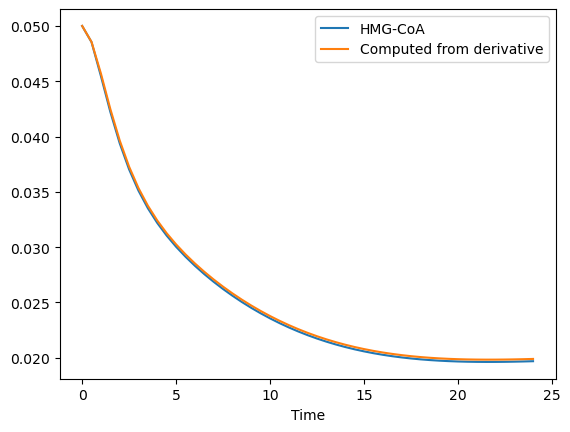

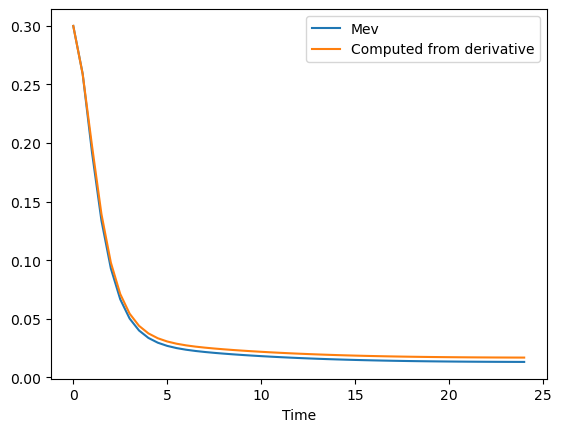

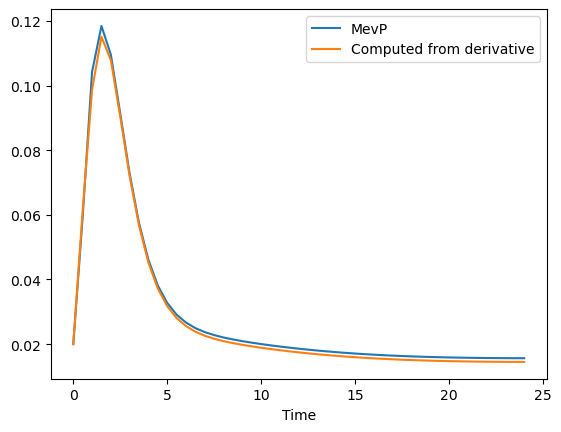

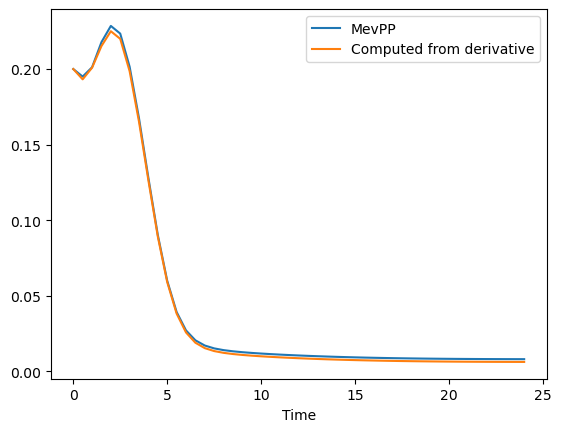

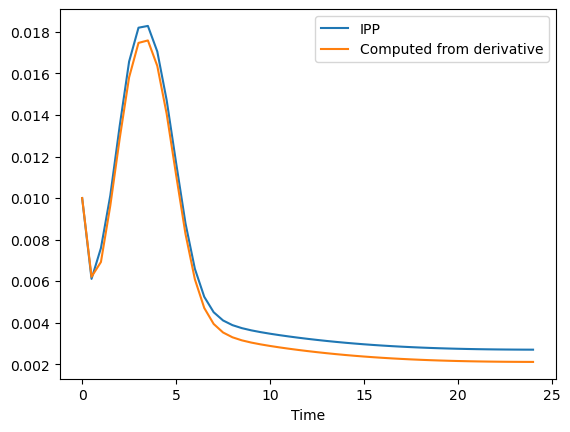

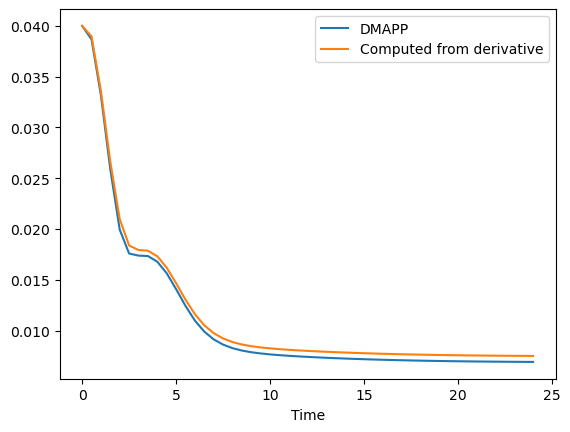

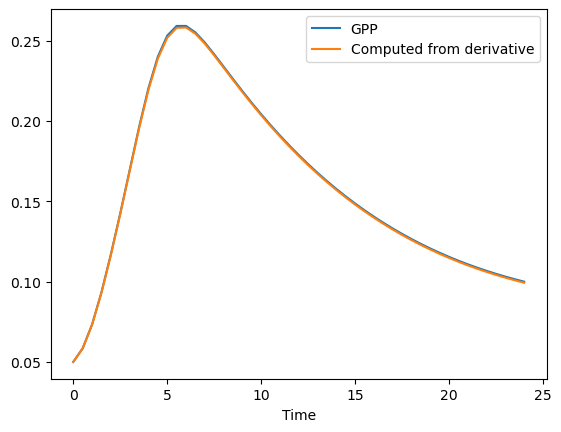

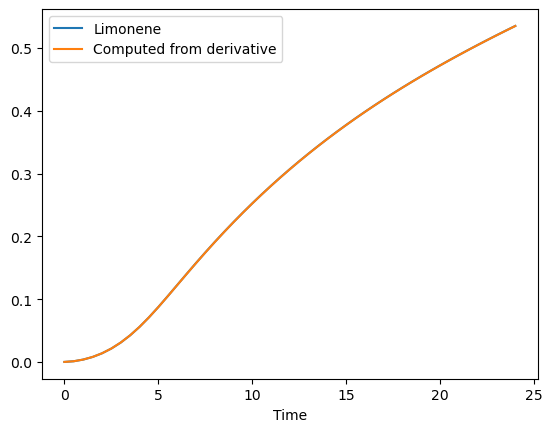

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                       AtoB          HMGS          HMGR            MK   
Strain   Time                                                           
Strain 1 0.0   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.5   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         1.0   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
         1.5   6.303323e+06  5.167157e+06  5.462870e+05  3.570656e+06   
         2.0   6.425365e+06  5.499584e+06  5.913288e+05  3.865639e+06   
...                     ...           ...           ...           ...   
WT       22.0  2.728742e+06  2.682996e+06  1.765870e+06  2.007241e+06   
         22.5  2.729080e+06  2.684265e+06  1.767009e+06  2.008539e+06   
         23.0  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.5  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         24.0  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.5   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         1.5   1.118956e+06  6.520026e+06  3.935836e+06  9.528769e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   
...                     ...           ...           ...           ...   
WT       22.0  1.500014e+06  3.984102e+06  4.352338e+06  1.233945e+06   
         22.5  1.500845e+06  3.987467e+06  4.353087e+06  1.234537e+06   
         23.0  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.5  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         24.0  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                    states                            \
              Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                          
Strain 1 0.0       3.034108e+01   0.300000        0.200000  0.050000   
         0.5       2.866143e+05   0.295498        0.200425  0.060938   
         1.0       3.981392e+05   0.272992        0.193767  0.078634   
         1.5       4.574783e+05   0.247259        0.183511  0.094572   
         2.0       4.943155e+05   0.222240        0.171758  0.106426   
...                         ...        ...             ...       ...   
WT       22.0      1.466213e+06   0.367253        0.093487  0.019629   
         22.5      1.467130e+06   0.368929        0.093382  0.019637   
         23.0      1.468009e+06   0.370558        0.093309  0.019650   
         23.5      1.468851e+06   0.372140        0.093264  0.019669   
         24.0      1.469659e+06   0.373674        0.093246  0.019692   

                                                                           \
                    Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                               
Strain 1 0.0   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.5   0.195920  0.112245  0.181601  0.014419  0.038643  0.064898   
         1.0   0.079861  0.171375  0.173169  0.020703  0.032371  0.100826   
         1.5   0.031327  0.148031  0.154712  0.027644  0.028134  0.149235   
         2.0   0.018138  0.106571  0.109090  0.029339  0.027014  0.204377   
...                 ...       ...       ...       ...       ...       ...   
WT       22.0  0.013205  0.015704  0.008120  0.002712  0.006941  0.106707   
         22.5  0.013167  0.015678  0.008096  0.002707  0.006934  0.104854   
         23.0  0.013135  0.015658  0.008076  0.002704  0.006927  0.103119   
         23.5  0.013108  0.015644  0.008

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0     0.011369        0.009301  0.013716 -0.220295  0.263219   
         0.5    -0.029353       -0.007065  0.029999 -0.220049  0.140752   
         1.0    -0.051358       -0.017845  0.035441 -0.172480  0.033286   
         1.5    -0.051664       -0.022533  0.028240 -0.052298 -0.080370   
         2.0    -0.048146       -0.024229  0.019254 -0.009927 -0.077197   
...                   ...             ...       ...       ...       ...   
WT       22.0    0.003397       -0.000246  0.000010 -0.000083 -0.000058   
         22.5    0.003306       -0.000178  0.000022 -0.000070 -0.000045   
         23.0    0.003212       -0.000116  0.000032 -0.000059 -0.000034   
         23.5    0.003116       -0.000061  0.000042 -0.000048 -0.000023   
         24.0    0.003018       -0.000013  0.000050 -0.000039 -0.000014   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.058123  0.002925  0.002783  0.005002  0.000218  
         0.5  -0.020846  0.012224 -0.008549  0.053008  0.001831  
         1.0  -0.020701  0.014411 -0.011848  0.086719  0.004028  
         1.5  -0.065010  0.010076 -0.004743  0.106262  0.006840  
         2.0  -0.103538 -0.005049 -0.003032  0.110230  0.010109  
...                 ...       ...       ...       ...       ...  
WT       22.0 -0.000053 -0.000010 -0.000016 -0.003828  0.015645  
         22.5 -0.000044 -0.000008 -0.000014 -0.003586  0.015383  
         23.0 -0.000035 -0.000006 -0.000012 -0.003355  0.015138  
         23.5 -0.000027 -0.000004 -0.000011 -0.003136  0.014908  
         24.0 -0.000020 -0.000002 -0.000009 -0.002928  0.014694  

[196 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem

# problem definition (object oriented to use population-based approach)
class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=34, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,-1.30103,0.0                         
                         ]), # lower bounds
                         xu=np.array([
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,-1.301029,9.0
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                      s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                      k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
                      k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
                      k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
        #HC: 53 parameters (9+10+12+12+10)
        r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
        r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
        r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
        r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
        r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
        r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
        r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
        r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
        
        return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
     
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [29]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [30]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e4)

In [31]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 |  3.137358E+34 |  1.143682E+19
     2 |      128 |  3.649654E+32 |  1.069211E+13
     3 |      192 |  3.369265E+32 |  6.361301E+06
     4 |      256 |  7.407504E+25 |  3.240558E+05
     5 |      320 |  3.824156E+13 |  2.471181E+04
     6 |      384 |  1.671587E+11 |  4.179303E+03
     7 |      448 |  9.415685E+07 |  2.008581E+03
     8 |      512 |  1.025327E+06 |  5.338210E+02
     9 |      576 |  1.013702E+06 |  1.992438E+02
    10 |      640 |  1.013004E+06 |  6.128606E+01
    11 |      704 |  1.330547E+02 |  3.874719E+01
    12 |      768 |  5.009275E+01 |  3.582414E+01
    13 |      832 |  4.042455E+01 |  3.468221E+01
    14 |      896 |  3.695883E+01 |  3.439936E+01
    15 |      960 |  3.443918E+01 |  3.389536E+01
    16 |     1024 |  3.408382E+01 |  3.362225E+01
    17 |     1088 |  3.353192E+01 |  3.252136E+01
    18 |     1152 |  3.218110E+01 |  3.023074E+01
    19 |     1216 |  3.04

   162 |    10368 |  1.365643E+01 |  1.364521E+01
   163 |    10432 |  1.364978E+01 |  1.363606E+01
   164 |    10496 |  1.363846E+01 |  1.362077E+01
   165 |    10560 |  1.362460E+01 |  1.360943E+01
   166 |    10624 |  1.361377E+01 |  1.360425E+01
   167 |    10688 |  1.360806E+01 |  1.360190E+01
   168 |    10752 |  1.360435E+01 |  1.360091E+01
   169 |    10816 |  1.360153E+01 |  1.360017E+01
   170 |    10880 |  1.360053E+01 |  1.359964E+01
   171 |    10944 |  1.358715E+01 |  1.356760E+01
   172 |    11008 |  1.356676E+01 |  1.353670E+01
   173 |    11072 |  1.354390E+01 |  1.349013E+01
   174 |    11136 |  1.350977E+01 |  1.345382E+01
   175 |    11200 |  1.346451E+01 |  1.341958E+01
   176 |    11264 |  1.342842E+01 |  1.338932E+01
   177 |    11328 |  1.340042E+01 |  1.337215E+01
   178 |    11392 |  1.338213E+01 |  1.336775E+01
   179 |    11456 |  1.336982E+01 |  1.336142E+01
   180 |    11520 |  1.336200E+01 |  1.335162E+01
   181 |    11584 |  1.335265E+01 |  1.334128E+01


   326 |    20864 |  9.6476207365 |  9.6453598920
   327 |    20928 |  9.6463599030 |  9.6447773286
   328 |    20992 |  9.6450239771 |  9.6430406136
   329 |    21056 |  9.6436846099 |  9.6417689810
   330 |    21120 |  9.6422729707 |  9.6389041379
   331 |    21184 |  9.6400144742 |  9.6369277149
   332 |    21248 |  9.6377333334 |  9.6349075052
   333 |    21312 |  9.6354265295 |  9.6332406306
   334 |    21376 |  9.6334486217 |  9.6309695501
   335 |    21440 |  9.6318694499 |  9.6299707428
   336 |    21504 |  9.6303478214 |  9.6290856568
   337 |    21568 |  9.6292003849 |  9.6281365387
   338 |    21632 |  9.6281336509 |  9.6267087817
   339 |    21696 |  9.6268422648 |  9.6257133004
   340 |    21760 |  9.6258186216 |  9.6243888416
   341 |    21824 |  9.6246365632 |  9.6234211584
   342 |    21888 |  9.6232324425 |  9.6214925580
   343 |    21952 |  9.6217506826 |  9.6205570435
   344 |    22016 |  9.6204546568 |  9.6191820541
   345 |    22080 |  9.6194038928 |  9.6180939760


   490 |    31360 |  7.6308603185 |  7.6299592689
   491 |    31424 |  7.6300388497 |  7.6293645205
   492 |    31488 |  7.6294187251 |  7.6289590905
   493 |    31552 |  7.6288630994 |  7.6280114898
   494 |    31616 |  7.6280882573 |  7.6275098460
   495 |    31680 |  7.6275608925 |  7.6269085692
   496 |    31744 |  7.6271424091 |  7.6265519653
   497 |    31808 |  7.6264241741 |  7.6254769703
   498 |    31872 |  7.6256073586 |  7.6245111978
   499 |    31936 |  7.6245194430 |  7.6229973234
   500 |    32000 |  7.6227583449 |  7.6204552672
   501 |    32064 |  7.6208911762 |  7.6187279900
   502 |    32128 |  7.6193538572 |  7.6174978351
   503 |    32192 |  7.6179134505 |  7.6162283663
   504 |    32256 |  7.6166390552 |  7.6155563061
   505 |    32320 |  7.6158067151 |  7.6147794793
   506 |    32384 |  7.6148176972 |  7.6140121249
   507 |    32448 |  7.6142479915 |  7.6136198617
   508 |    32512 |  7.6137531232 |  7.6131344341
   509 |    32576 |  7.6132695578 |  7.6127041783


   654 |    41856 |  7.5878350586 |  7.5878203305
   655 |    41920 |  7.5878235097 |  7.5878077693
   656 |    41984 |  7.5878131069 |  7.5878021079
   657 |    42048 |  7.5878028885 |  7.5877926031
   658 |    42112 |  7.5877928773 |  7.5877827485
   659 |    42176 |  7.5877842157 |  7.5877737865
   660 |    42240 |  7.5877777048 |  7.5877729971
   661 |    42304 |  7.5877738115 |  7.5877693764
   662 |    42368 |  7.5877709116 |  7.5877661723
   663 |    42432 |  7.5877660909 |  7.5877603913
   664 |    42496 |  7.5877626575 |  7.5877589976
   665 |    42560 |  7.5877605088 |  7.5877572338
   666 |    42624 |  7.5877568784 |  7.5877497119
   667 |    42688 |  7.5877506485 |  7.5877427135
   668 |    42752 |  7.5877457365 |  7.5877389484
   669 |    42816 |  7.5877409594 |  7.5877349605
   670 |    42880 |  7.5877361730 |  7.5877316380
   671 |    42944 |  7.5877326967 |  7.5877285855
   672 |    43008 |  7.5877287978 |  7.5877250558
   673 |    43072 |  7.5877254616 |  7.5877209745


   818 |    52352 |  7.5861278264 |  7.5861172074
   819 |    52416 |  7.5861200766 |  7.5861090062
   820 |    52480 |  7.5861118197 |  7.5861051482
   821 |    52544 |  7.5861066331 |  7.5861010669
   822 |    52608 |  7.5861019455 |  7.5860981208
   823 |    52672 |  7.5860995688 |  7.5860965360
   824 |    52736 |  7.5860972229 |  7.5860950144
   825 |    52800 |  7.5860950281 |  7.5860930824
   826 |    52864 |  7.5860937903 |  7.5860919959
   827 |    52928 |  7.5860927711 |  7.5860913967
   828 |    52992 |  7.5860917324 |  7.5860906833
   829 |    53056 |  7.5860909168 |  7.5860901239
   830 |    53120 |  7.5860903736 |  7.5860895787
   831 |    53184 |  7.5860897192 |  7.5860889533
   832 |    53248 |  7.5860891890 |  7.5860885722
   833 |    53312 |  7.5860887055 |  7.5860880712
   834 |    53376 |  7.5860882925 |  7.5860878244
   835 |    53440 |  7.5860880689 |  7.5860877075
   836 |    53504 |  7.5860878056 |  7.5860875109
   837 |    53568 |  7.5860876294 |  7.5860873620


   982 |    62848 |  7.5846765222 |  7.5846765221
   983 |    62912 |  7.5846765221 |  7.5846765220
   984 |    62976 |  7.5846765220 |  7.5846765219
   985 |    63040 |  7.5846765219 |  7.5846765218
   986 |    63104 |  7.5846765219 |  7.5846765218
   987 |    63168 |  7.5846765218 |  7.5846765217
   988 |    63232 |  7.5846765218 |  7.5846765217
   989 |    63296 |  7.5846765217 |  7.5846765216
   990 |    63360 |  7.5846765216 |  7.5846765215
   991 |    63424 |  7.5846765215 |  7.5846765214
   992 |    63488 |  7.5846765214 |  7.5846765213
   993 |    63552 |  7.5846765213 |  7.5846765211
   994 |    63616 |  7.5846765211 |  7.5846765210
   995 |    63680 |  7.5846765211 |  7.5846765209
   996 |    63744 |  7.5846765210 |  7.5846765209
   997 |    63808 |  7.5846765209 |  7.5846765208
   998 |    63872 |  7.5846765208 |  7.5846765207
   999 |    63936 |  7.5846765207 |  7.5846765207
  1000 |    64000 |  7.5846765207 |  7.5846765207
  1001 |    64064 |  7.5846765207 |  7.5846765207


  1146 |    73344 |  7.5845951033 |  7.5845950813
  1147 |    73408 |  7.5845950890 |  7.5845950712
  1148 |    73472 |  7.5845950776 |  7.5845950643
  1149 |    73536 |  7.5845950669 |  7.5845950536
  1150 |    73600 |  7.5845950507 |  7.5845950282
  1151 |    73664 |  7.5845950276 |  7.5845949860
  1152 |    73728 |  7.5845949955 |  7.5845949570
  1153 |    73792 |  7.5845949657 |  7.5845949209
  1154 |    73856 |  7.5845949229 |  7.5845949030
  1155 |    73920 |  7.5845948986 |  7.5845948663
  1156 |    73984 |  7.5845948676 |  7.5845948354
  1157 |    74048 |  7.5845948359 |  7.5845947975
  1158 |    74112 |  7.5845948050 |  7.5845947734
  1159 |    74176 |  7.5845947775 |  7.5845947469
  1160 |    74240 |  7.5845947546 |  7.5845947289
  1161 |    74304 |  7.5845947323 |  7.5845947001
  1162 |    74368 |  7.5845947049 |  7.5845946765
  1163 |    74432 |  7.5845946805 |  7.5845946579
  1164 |    74496 |  7.5845946591 |  7.5845946361
  1165 |    74560 |  7.5845946385 |  7.5845946067


  1310 |    83840 |  7.5843668810 |  7.5843641311
  1311 |    83904 |  7.5843653877 |  7.5843630092
  1312 |    83968 |  7.5843642421 |  7.5843616345
  1313 |    84032 |  7.5843625465 |  7.5843606434
  1314 |    84096 |  7.5843612058 |  7.5843600217
  1315 |    84160 |  7.5843602834 |  7.5843594441
  1316 |    84224 |  7.5843598213 |  7.5843591041
  1317 |    84288 |  7.5843593081 |  7.5843586131
  1318 |    84352 |  7.5843587249 |  7.5843582009
  1319 |    84416 |  7.5843584673 |  7.5843581752
  1320 |    84480 |  7.5843581947 |  7.5843577805
  1321 |    84544 |  7.5843578491 |  7.5843574892
  1322 |    84608 |  7.5843575972 |  7.5843572582
  1323 |    84672 |  7.5843573844 |  7.5843571035
  1324 |    84736 |  7.5843571961 |  7.5843568916
  1325 |    84800 |  7.5843570376 |  7.5843567674
  1326 |    84864 |  7.5843568808 |  7.5843566480
  1327 |    84928 |  7.5843567487 |  7.5843566032
  1328 |    84992 |  7.5843566621 |  7.5843565351
  1329 |    85056 |  7.5843565728 |  7.5843564106


  1474 |    94336 |  7.5843095645 |  7.5843094348
  1475 |    94400 |  7.5843094673 |  7.5843093440
  1476 |    94464 |  7.5843093644 |  7.5843092622
  1477 |    94528 |  7.5843092827 |  7.5843091835
  1478 |    94592 |  7.5843091927 |  7.5843091009
  1479 |    94656 |  7.5843090911 |  7.5843089643
  1480 |    94720 |  7.5843089770 |  7.5843088523
  1481 |    94784 |  7.5843088861 |  7.5843088166
  1482 |    94848 |  7.5843088315 |  7.5843087476
  1483 |    94912 |  7.5843087500 |  7.5843086447
  1484 |    94976 |  7.5843086346 |  7.5843084657
  1485 |    95040 |  7.5843084791 |  7.5843082748
  1486 |    95104 |  7.5843082341 |  7.5843077526
  1487 |    95168 |  7.5843077356 |  7.5843071212
  1488 |    95232 |  7.5843070715 |  7.5843059951
  1489 |    95296 |  7.5843060952 |  7.5843048587
  1490 |    95360 |  7.5843049714 |  7.5843036303
  1491 |    95424 |  7.5843041630 |  7.5843034055
  1492 |    95488 |  7.5843037743 |  7.5843033905
  1493 |    95552 |  7.5843035251 |  7.5843033669


  1638 |   104832 |  7.5842980452 |  7.5842965557
  1639 |   104896 |  7.5842968849 |  7.5842962942
  1640 |   104960 |  7.5842965667 |  7.5842962933
  1641 |   105024 |  7.5842964128 |  7.5842962931
  1642 |   105088 |  7.5842963083 |  7.5842962929
  1643 |   105152 |  7.5842963051 |  7.5842962927
  1644 |   105216 |  7.5842962915 |  7.5842962855
  1645 |   105280 |  7.5842962824 |  7.5842962572
  1646 |   105344 |  7.5842962678 |  7.5842962355
  1647 |   105408 |  7.5842962409 |  7.5842962053
  1648 |   105472 |  7.5842962042 |  7.5842961541
  1649 |   105536 |  7.5842961571 |  7.5842961184
  1650 |   105600 |  7.5842961320 |  7.5842961106
  1651 |   105664 |  7.5842961142 |  7.5842960994
  1652 |   105728 |  7.5842960991 |  7.5842960721
  1653 |   105792 |  7.5842960808 |  7.5842960530
  1654 |   105856 |  7.5842960576 |  7.5842960309
  1655 |   105920 |  7.5842960393 |  7.5842960145
  1656 |   105984 |  7.5842960219 |  7.5842960033
  1657 |   106048 |  7.5842960009 |  7.5842959616


  1802 |   115328 |  7.5841671605 |  7.5841670346
  1803 |   115392 |  7.5841670364 |  7.5841668614
  1804 |   115456 |  7.5841668873 |  7.5841667612
  1805 |   115520 |  7.5841667827 |  7.5841667001
  1806 |   115584 |  7.5841667135 |  7.5841666317
  1807 |   115648 |  7.5841666420 |  7.5841665828
  1808 |   115712 |  7.5841665886 |  7.5841665467
  1809 |   115776 |  7.5841665529 |  7.5841664967
  1810 |   115840 |  7.5841665022 |  7.5841664415
  1811 |   115904 |  7.5841664607 |  7.5841664170
  1812 |   115968 |  7.5841664095 |  7.5841663567
  1813 |   116032 |  7.5841663794 |  7.5841663316
  1814 |   116096 |  7.5841663294 |  7.5841662817
  1815 |   116160 |  7.5841662690 |  7.5841661657
  1816 |   116224 |  7.5841661918 |  7.5841661215
  1817 |   116288 |  7.5841661204 |  7.5841660399
  1818 |   116352 |  7.5841660465 |  7.5841659630
  1819 |   116416 |  7.5841659755 |  7.5841658736
  1820 |   116480 |  7.5841658671 |  7.5841657481
  1821 |   116544 |  7.5841657709 |  7.5841656380


  1966 |   125824 |  7.5841637196 |  7.5841637058
  1967 |   125888 |  7.5841637063 |  7.5841636894
  1968 |   125952 |  7.5841636798 |  7.5841636398
  1969 |   126016 |  7.5841636487 |  7.5841636131
  1970 |   126080 |  7.5841636152 |  7.5841635801
  1971 |   126144 |  7.5841635796 |  7.5841635227
  1972 |   126208 |  7.5841635161 |  7.5841634525
  1973 |   126272 |  7.5841634595 |  7.5841633780
  1974 |   126336 |  7.5841633639 |  7.5841632322
  1975 |   126400 |  7.5841631934 |  7.5841629238
  1976 |   126464 |  7.5841629360 |  7.5841626131
  1977 |   126528 |  7.5841625330 |  7.5841621941
  1978 |   126592 |  7.5841623497 |  7.5841621836
  1979 |   126656 |  7.5841622780 |  7.5841621819
  1980 |   126720 |  7.5841621815 |  7.5841621680
  1981 |   126784 |  7.5841621697 |  7.5841621436
  1982 |   126848 |  7.5841621533 |  7.5841621272
  1983 |   126912 |  7.5841621349 |  7.5841620868
  1984 |   126976 |  7.5841620960 |  7.5841620583
  1985 |   127040 |  7.5841620786 |  7.5841620451


  2130 |   136320 |  7.5840473808 |  7.5840473765
  2131 |   136384 |  7.5840473777 |  7.5840473736
  2132 |   136448 |  7.5840473746 |  7.5840473706
  2133 |   136512 |  7.5840473719 |  7.5840473679
  2134 |   136576 |  7.5840473691 |  7.5840473655
  2135 |   136640 |  7.5840473656 |  7.5840473595
  2136 |   136704 |  7.5840473615 |  7.5840473558
  2137 |   136768 |  7.5840473576 |  7.5840473529
  2138 |   136832 |  7.5840473538 |  7.5840473482
  2139 |   136896 |  7.5840473490 |  7.5840473430
  2140 |   136960 |  7.5840473446 |  7.5840473406
  2141 |   137024 |  7.5840473423 |  7.5840473391
  2142 |   137088 |  7.5840473397 |  7.5840473370
  2143 |   137152 |  7.5840473377 |  7.5840473346
  2144 |   137216 |  7.5840473359 |  7.5840473331
  2145 |   137280 |  7.5840473333 |  7.5840473309
  2146 |   137344 |  7.5840473311 |  7.5840473286
  2147 |   137408 |  7.5840473293 |  7.5840473277
  2148 |   137472 |  7.5840473283 |  7.5840473267
  2149 |   137536 |  7.5840473273 |  7.5840473260


  2294 |   146816 |  7.5836946698 |  7.5836940215
  2295 |   146880 |  7.5836941063 |  7.5836932044
  2296 |   146944 |  7.5836934676 |  7.5836924797
  2297 |   147008 |  7.5836929088 |  7.5836918419
  2298 |   147072 |  7.5836921355 |  7.5836906000
  2299 |   147136 |  7.5836911314 |  7.5836899990
  2300 |   147200 |  7.5836904171 |  7.5836895069
  2301 |   147264 |  7.5836897740 |  7.5836884482
  2302 |   147328 |  7.5836888134 |  7.5836877505
  2303 |   147392 |  7.5836880361 |  7.5836871156
  2304 |   147456 |  7.5836872053 |  7.5836858044
  2305 |   147520 |  7.5836862638 |  7.5836852501
  2306 |   147584 |  7.5836853410 |  7.5836842391
  2307 |   147648 |  7.5836844545 |  7.5836832933
  2308 |   147712 |  7.5836834051 |  7.5836817610
  2309 |   147776 |  7.5836823219 |  7.5836811631
  2310 |   147840 |  7.5836814562 |  7.5836802985
  2311 |   147904 |  7.5836804372 |  7.5836790530
  2312 |   147968 |  7.5836791742 |  7.5836774336
  2313 |   148032 |  7.5836782418 |  7.5836765342


  2458 |   157312 |  7.5836686710 |  7.5836684828
  2459 |   157376 |  7.5836685184 |  7.5836682996
  2460 |   157440 |  7.5836683818 |  7.5836682481
  2461 |   157504 |  7.5836682712 |  7.5836681162
  2462 |   157568 |  7.5836681470 |  7.5836679653
  2463 |   157632 |  7.5836680097 |  7.5836676767
  2464 |   157696 |  7.5836677803 |  7.5836673632
  2465 |   157760 |  7.5836674362 |  7.5836669281
  2466 |   157824 |  7.5836669460 |  7.5836663092
  2467 |   157888 |  7.5836664799 |  7.5836661325
  2468 |   157952 |  7.5836661533 |  7.5836659460
  2469 |   158016 |  7.5836660061 |  7.5836657959
  2470 |   158080 |  7.5836658476 |  7.5836657489
  2471 |   158144 |  7.5836657689 |  7.5836656809
  2472 |   158208 |  7.5836657172 |  7.5836656617
  2473 |   158272 |  7.5836656556 |  7.5836655953
  2474 |   158336 |  7.5836656103 |  7.5836655776
  2475 |   158400 |  7.5836655918 |  7.5836655591
  2476 |   158464 |  7.5836655674 |  7.5836655317
  2477 |   158528 |  7.5836655457 |  7.5836655160


  2622 |   167808 |  7.5834823364 |  7.5834816849
  2623 |   167872 |  7.5834818164 |  7.5834810418
  2624 |   167936 |  7.5834811686 |  7.5834799503
  2625 |   168000 |  7.5834804596 |  7.5834795638
  2626 |   168064 |  7.5834797280 |  7.5834791278
  2627 |   168128 |  7.5834793032 |  7.5834788196
  2628 |   168192 |  7.5834790174 |  7.5834785328
  2629 |   168256 |  7.5834786742 |  7.5834782219
  2630 |   168320 |  7.5834783531 |  7.5834780054
  2631 |   168384 |  7.5834780918 |  7.5834778318
  2632 |   168448 |  7.5834779483 |  7.5834776827
  2633 |   168512 |  7.5834777667 |  7.5834775197
  2634 |   168576 |  7.5834775884 |  7.5834773904
  2635 |   168640 |  7.5834774853 |  7.5834772937
  2636 |   168704 |  7.5834773676 |  7.5834771721
  2637 |   168768 |  7.5834772140 |  7.5834769480
  2638 |   168832 |  7.5834769781 |  7.5834766003
  2639 |   168896 |  7.5834767247 |  7.5834764007
  2640 |   168960 |  7.5834764888 |  7.5834761640
  2641 |   169024 |  7.5834762823 |  7.5834759931


  2786 |   178304 |  7.5834677860 |  7.5834677850
  2787 |   178368 |  7.5834677852 |  7.5834677844
  2788 |   178432 |  7.5834677846 |  7.5834677837
  2789 |   178496 |  7.5834512064 |  7.5834260244
  2790 |   178560 |  7.5834372473 |  7.5834259963
  2791 |   178624 |  7.5834306218 |  7.5834259218
  2792 |   178688 |  7.5834269162 |  7.5834198731
  2793 |   178752 |  7.5834201308 |  7.5834132438
  2794 |   178816 |  7.5834128824 |  7.5834027285
  2795 |   178880 |  7.5834057603 |  7.5833962966
  2796 |   178944 |  7.5833991359 |  7.5833909748
  2797 |   179008 |  7.5833932938 |  7.5833879198
  2798 |   179072 |  7.5833892953 |  7.5833849886
  2799 |   179136 |  7.5833853755 |  7.5833817993
  2800 |   179200 |  7.5833828994 |  7.5833804960
  2801 |   179264 |  7.5833813234 |  7.5833795718
  2802 |   179328 |  7.5833800671 |  7.5833788253
  2803 |   179392 |  7.5833790104 |  7.5833781149
  2804 |   179456 |  7.5833782741 |  7.5833774173
  2805 |   179520 |  7.5833776987 |  7.5833769896


  2950 |   188800 |  7.5833518068 |  7.5833517809
  2951 |   188864 |  7.5833517840 |  7.5833517620
  2952 |   188928 |  7.5833517641 |  7.5833517418
  2953 |   188992 |  7.5833517463 |  7.5833517235
  2954 |   189056 |  7.5833517319 |  7.5833517164
  2955 |   189120 |  7.5833517173 |  7.5833516990
  2956 |   189184 |  7.5833517030 |  7.5833516934
  2957 |   189248 |  7.5833516951 |  7.5833516819
  2958 |   189312 |  7.5833516845 |  7.5833516714
  2959 |   189376 |  7.5833516739 |  7.5833516593
  2960 |   189440 |  7.5833516573 |  7.5833516399
  2961 |   189504 |  7.5833516360 |  7.5833516108
  2962 |   189568 |  7.5833516148 |  7.5833515877
  2963 |   189632 |  7.5833515941 |  7.5833515713
  2964 |   189696 |  7.5833515772 |  7.5833515607
  2965 |   189760 |  7.5833515672 |  7.5833515542
  2966 |   189824 |  7.5833515593 |  7.5833515496
  2967 |   189888 |  7.5833515520 |  7.5833515450
  2968 |   189952 |  7.5833515472 |  7.5833515408
  2969 |   190016 |  7.5833515422 |  7.5833515365


  3114 |   199296 |  7.5833258694 |  7.5833258645
  3115 |   199360 |  7.5833258660 |  7.5833258616
  3116 |   199424 |  7.5833258630 |  7.5833258602
  3117 |   199488 |  7.5833258612 |  7.5833258590
  3118 |   199552 |  7.5833258597 |  7.5833258584
  3119 |   199616 |  7.5833258588 |  7.5833258578
  3120 |   199680 |  7.5833258578 |  7.5833258565
  3121 |   199744 |  7.5833258567 |  7.5833258553
  3122 |   199808 |  7.5833258558 |  7.5833258542
  3123 |   199872 |  7.5833258544 |  7.5833258525
  3124 |   199936 |  7.5833258525 |  7.5833258505
  3125 |   200000 |  7.5833258508 |  7.5833258492
  3126 |   200064 |  7.5833258499 |  7.5833258484
  3127 |   200128 |  7.5833258486 |  7.5833258472
  3128 |   200192 |  7.5833258475 |  7.5833258463
  3129 |   200256 |  7.5833258460 |  7.5833258444
  3130 |   200320 |  7.5833258448 |  7.5833258433
  3131 |   200384 |  7.5833258439 |  7.5833258425
  3132 |   200448 |  7.5833258430 |  7.5833258422
  3133 |   200512 |  7.5833258425 |  7.5833258418


  3278 |   209792 |  7.5832491224 |  7.5832491136
  3279 |   209856 |  7.5832491146 |  7.5832491055
  3280 |   209920 |  7.5832491081 |  7.5832490979
  3281 |   209984 |  7.5832491001 |  7.5832490921
  3282 |   210048 |  7.5832490955 |  7.5832490863
  3283 |   210112 |  7.5832490886 |  7.5832490816
  3284 |   210176 |  7.5832490828 |  7.5832490784
  3285 |   210240 |  7.5832490796 |  7.5832490758
  3286 |   210304 |  7.5832490770 |  7.5832490739
  3287 |   210368 |  7.5832490752 |  7.5832490723
  3288 |   210432 |  7.5832490729 |  7.5832490703
  3289 |   210496 |  7.5832490714 |  7.5832490696
  3290 |   210560 |  7.5832490699 |  7.5832490675
  3291 |   210624 |  7.5832490678 |  7.5832490653
  3292 |   210688 |  7.5832490657 |  7.5832490627
  3293 |   210752 |  7.5832490643 |  7.5832490622
  3294 |   210816 |  7.5832490624 |  7.5832490599
  3295 |   210880 |  7.5832490608 |  7.5832490594
  3296 |   210944 |  7.5832490594 |  7.5832490576
  3297 |   211008 |  7.5832490580 |  7.5832490567


  3442 |   220288 |  7.5832366666 |  7.5832366623
  3443 |   220352 |  7.5832366641 |  7.5832366597
  3444 |   220416 |  7.5832366607 |  7.5832366571
  3445 |   220480 |  7.5832366577 |  7.5832366547
  3446 |   220544 |  7.5832366557 |  7.5832366528
  3447 |   220608 |  7.5832366541 |  7.5832366518
  3448 |   220672 |  7.5832366527 |  7.5832366508
  3449 |   220736 |  7.5832366512 |  7.5832366502
  3450 |   220800 |  7.5832366504 |  7.5832366493
  3451 |   220864 |  7.5832366496 |  7.5832366488
  3452 |   220928 |  7.5832366486 |  7.5832366473
  3453 |   220992 |  7.5832366477 |  7.5832366463
  3454 |   221056 |  7.5832366466 |  7.5832366450
  3455 |   221120 |  7.5832366457 |  7.5832366438
  3456 |   221184 |  7.5832366442 |  7.5832366427
  3457 |   221248 |  7.5832366434 |  7.5832366423
  3458 |   221312 |  7.5832366427 |  7.5832366420
  3459 |   221376 |  7.5832366422 |  7.5832366415
  3460 |   221440 |  7.5832366419 |  7.5832366414
  3461 |   221504 |  7.5832366416 |  7.5832366413


  3606 |   230784 |  7.5832279399 |  7.5832279300
  3607 |   230848 |  7.5832279302 |  7.5832279184
  3608 |   230912 |  7.5832279232 |  7.5832279167
  3609 |   230976 |  7.5832279187 |  7.5832279128
  3610 |   231040 |  7.5832279142 |  7.5832279103
  3611 |   231104 |  7.5832279116 |  7.5832279076
  3612 |   231168 |  7.5832279083 |  7.5832279033
  3613 |   231232 |  7.5832279047 |  7.5832279016
  3614 |   231296 |  7.5832279022 |  7.5832278986
  3615 |   231360 |  7.5832278999 |  7.5832278971
  3616 |   231424 |  7.5832278982 |  7.5832278961
  3617 |   231488 |  7.5832278969 |  7.5832278953
  3618 |   231552 |  7.5832278959 |  7.5832278948
  3619 |   231616 |  7.5832278951 |  7.5832278935
  3620 |   231680 |  7.5832278941 |  7.5832278924
  3621 |   231744 |  7.5832278933 |  7.5832278917
  3622 |   231808 |  7.5832278924 |  7.5832278913
  3623 |   231872 |  7.5832278916 |  7.5832278904
  3624 |   231936 |  7.5832278905 |  7.5832278895
  3625 |   232000 |  7.5832278900 |  7.5832278884


  3770 |   241280 |  7.5832263993 |  7.5832263496
  3771 |   241344 |  7.5832263641 |  7.5832263322
  3772 |   241408 |  7.5832263302 |  7.5832262912
  3773 |   241472 |  7.5832263067 |  7.5832262790
  3774 |   241536 |  7.5832262777 |  7.5832262547
  3775 |   241600 |  7.5832262624 |  7.5832262450
  3776 |   241664 |  7.5832262510 |  7.5832262297
  3777 |   241728 |  7.5832262339 |  7.5832262030
  3778 |   241792 |  7.5832262148 |  7.5832261790
  3779 |   241856 |  7.5832261914 |  7.5832261677
  3780 |   241920 |  7.5832261729 |  7.5832261547
  3781 |   241984 |  7.5832261587 |  7.5832261435
  3782 |   242048 |  7.5832261490 |  7.5832261372
  3783 |   242112 |  7.5832261383 |  7.5832261253
  3784 |   242176 |  7.5832261306 |  7.5832261175
  3785 |   242240 |  7.5832261199 |  7.5832261110
  3786 |   242304 |  7.5832261133 |  7.5832261033
  3787 |   242368 |  7.5832261056 |  7.5832260953
  3788 |   242432 |  7.5832260987 |  7.5832260915
  3789 |   242496 |  7.5832260942 |  7.5832260879


  3934 |   251776 |  7.5832238182 |  7.5832238156
  3935 |   251840 |  7.5832238155 |  7.5832238119
  3936 |   251904 |  7.5832238122 |  7.5832238086
  3937 |   251968 |  7.5832238095 |  7.5832238058
  3938 |   252032 |  7.5832238066 |  7.5832238034
  3939 |   252096 |  7.5832238038 |  7.5832238006
  3940 |   252160 |  7.5832238007 |  7.5832237977
  3941 |   252224 |  7.5832237973 |  7.5832237941
  3942 |   252288 |  7.5832237948 |  7.5832237911
  3943 |   252352 |  7.5832237918 |  7.5832237885
  3944 |   252416 |  7.5832237891 |  7.5832237873
  3945 |   252480 |  7.5832237874 |  7.5832237858
  3946 |   252544 |  7.5832237859 |  7.5832237845
  3947 |   252608 |  7.5832237848 |  7.5832237838
  3948 |   252672 |  7.5832237840 |  7.5832237831
  3949 |   252736 |  7.5832237834 |  7.5832237828
  3950 |   252800 |  7.5832237828 |  7.5832237821
  3951 |   252864 |  7.5832237821 |  7.5832237815
  3952 |   252928 |  7.5832237814 |  7.5832237806
  3953 |   252992 |  7.5832237808 |  7.5832237803


  4098 |   262272 |  7.5828945654 |  7.5828936940
  4099 |   262336 |  7.5828938663 |  7.5828930794
  4100 |   262400 |  7.5828932653 |  7.5828926832
  4101 |   262464 |  7.5828928984 |  7.5828922926
  4102 |   262528 |  7.5828925537 |  7.5828919242
  4103 |   262592 |  7.5828921877 |  7.5828918242
  4104 |   262656 |  7.5828919127 |  7.5828914313
  4105 |   262720 |  7.5828914973 |  7.5828910500
  4106 |   262784 |  7.5828911797 |  7.5828906353
  4107 |   262848 |  7.5828908363 |  7.5828904495
  4108 |   262912 |  7.5828906003 |  7.5828902559
  4109 |   262976 |  7.5828903673 |  7.5828900793
  4110 |   263040 |  7.5828902120 |  7.5828899236
  4111 |   263104 |  7.5828900260 |  7.5828898362
  4112 |   263168 |  7.5828899080 |  7.5828897545
  4113 |   263232 |  7.5828898331 |  7.5828897220
  4114 |   263296 |  7.5828897438 |  7.5828896400
  4115 |   263360 |  7.5828896809 |  7.5828896212
  4116 |   263424 |  7.5828896456 |  7.5828896018
  4117 |   263488 |  7.5828896188 |  7.5828895865


  4262 |   272768 |  7.5828484128 |  7.5828483809
  4263 |   272832 |  7.5828483940 |  7.5828483725
  4264 |   272896 |  7.5828483760 |  7.5828483616
  4265 |   272960 |  7.5828483602 |  7.5828483434
  4266 |   273024 |  7.5828483436 |  7.5828483254
  4267 |   273088 |  7.5828483291 |  7.5828483143
  4268 |   273152 |  7.5828483164 |  7.5828483040
  4269 |   273216 |  7.5828483050 |  7.5828482882
  4270 |   273280 |  7.5828482949 |  7.5828482822
  4271 |   273344 |  7.5828482833 |  7.5828482748
  4272 |   273408 |  7.5828482764 |  7.5828482670
  4273 |   273472 |  7.5828482699 |  7.5828482558
  4274 |   273536 |  7.5828482524 |  7.5828482325
  4275 |   273600 |  7.5828482357 |  7.5828482194
  4276 |   273664 |  7.5828482209 |  7.5828482064
  4277 |   273728 |  7.5828482101 |  7.5828481936
  4278 |   273792 |  7.5828481937 |  7.5828481694
  4279 |   273856 |  7.5828481690 |  7.5828481404
  4280 |   273920 |  7.5828481464 |  7.5828481270
  4281 |   273984 |  7.5828481299 |  7.5828481071


  4426 |   283264 |  7.5828449546 |  7.5828449546
  4427 |   283328 |  7.5828449546 |  7.5828449546
  4428 |   283392 |  7.5828449546 |  7.5828449546
  4429 |   283456 |  7.5828449546 |  7.5828449546
  4430 |   283520 |  7.5828449546 |  7.5828449546
  4431 |   283584 |  7.5828449546 |  7.5828449545
  4432 |   283648 |  7.5828449546 |  7.5828449545
  4433 |   283712 |  7.5828449545 |  7.5828449545
  4434 |   283776 |  7.5828449545 |  7.5828449545
  4435 |   283840 |  7.5828449545 |  7.5828449545
  4436 |   283904 |  7.5828449545 |  7.5828449545
  4437 |   283968 |  7.5828449545 |  7.5828449545
  4438 |   284032 |  7.5828449545 |  7.5828449545
  4439 |   284096 |  7.5828449545 |  7.5828449545
  4440 |   284160 |  7.5828449545 |  7.5828449545
  4441 |   284224 |  7.5828449545 |  7.5828449545
  4442 |   284288 |  7.5828449545 |  7.5828449545
  4443 |   284352 |  7.5828449545 |  7.5828449545
  4444 |   284416 |  7.5828449545 |  7.5828449545
  4445 |   284480 |  7.5828449545 |  7.5828449545


  4590 |   293760 |  7.5828442902 |  7.5828442902
  4591 |   293824 |  7.5828442902 |  7.5828442902
  4592 |   293888 |  7.5828442902 |  7.5828442902
  4593 |   293952 |  7.5828442902 |  7.5828442902
  4594 |   294016 |  7.5828442902 |  7.5828442902
  4595 |   294080 |  7.5828442902 |  7.5828442902
  4596 |   294144 |  7.5828442902 |  7.5828442902
  4597 |   294208 |  7.5828442902 |  7.5828442902
  4598 |   294272 |  7.5828442902 |  7.5828442902
  4599 |   294336 |  7.5828442902 |  7.5828442902
  4600 |   294400 |  7.5828442902 |  7.5828442902
  4601 |   294464 |  7.5828442902 |  7.5828442902
  4602 |   294528 |  7.5828442902 |  7.5828442902
  4603 |   294592 |  7.5828442902 |  7.5828442902
  4604 |   294656 |  7.5828442902 |  7.5828442902
  4605 |   294720 |  7.5828442902 |  7.5828442902
  4606 |   294784 |  7.5828442902 |  7.5828442902
  4607 |   294848 |  7.5828442902 |  7.5828442902
  4608 |   294912 |  7.5828442902 |  7.5828442902
  4609 |   294976 |  7.5828442902 |  7.5828442902


  4754 |   304256 |  7.5828442902 |  7.5828442902
  4755 |   304320 |  7.5828442902 |  7.5828442902
  4756 |   304384 |  7.5828442902 |  7.5828442902
  4757 |   304448 |  7.5828442902 |  7.5828442902
  4758 |   304512 |  7.5828442902 |  7.5828442902
  4759 |   304576 |  7.5828442902 |  7.5828442902
  4760 |   304640 |  7.5828442902 |  7.5828442902
  4761 |   304704 |  7.5828442902 |  7.5828442902
  4762 |   304768 |  7.5828417450 |  7.5828263948
  4763 |   304832 |  7.5828300527 |  7.5828210436
  4764 |   304896 |  7.5828246441 |  7.5828210436
  4765 |   304960 |  7.5828222875 |  7.5828210436
  4766 |   305024 |  7.5828214351 |  7.5828210436
  4767 |   305088 |  7.5828210714 |  7.5828210436
  4768 |   305152 |  7.5828210714 |  7.5828210436
  4769 |   305216 |  7.5828210436 |  7.5828210436
  4770 |   305280 |  7.5828210436 |  7.5828210436
  4771 |   305344 |  7.5828210436 |  7.5828210436
  4772 |   305408 |  7.5828210436 |  7.5828210436
  4773 |   305472 |  7.5828210436 |  7.5828210436


  4918 |   314752 |  7.5827724794 |  7.5827722489
  4919 |   314816 |  7.5827723464 |  7.5827721704
  4920 |   314880 |  7.5827722069 |  7.5827720423
  4921 |   314944 |  7.5827720929 |  7.5827719236
  4922 |   315008 |  7.5827719926 |  7.5827718618
  4923 |   315072 |  7.5827719192 |  7.5827717997
  4924 |   315136 |  7.5827718374 |  7.5827716752
  4925 |   315200 |  7.5827717590 |  7.5827715986
  4926 |   315264 |  7.5827716601 |  7.5827715134
  4927 |   315328 |  7.5827715901 |  7.5827714872
  4928 |   315392 |  7.5827715295 |  7.5827714557
  4929 |   315456 |  7.5827714608 |  7.5827713091
  4930 |   315520 |  7.5827713396 |  7.5827711652
  4931 |   315584 |  7.5827712158 |  7.5827710525
  4932 |   315648 |  7.5827711285 |  7.5827710382
  4933 |   315712 |  7.5827709650 |  7.5827706236
  4934 |   315776 |  7.5827707526 |  7.5827705511
  4935 |   315840 |  7.5827706373 |  7.5827705041
  4936 |   315904 |  7.5827705353 |  7.5827703297
  4937 |   315968 |  7.5827704126 |  7.5827702090


  5082 |   325248 |  7.5827256853 |  7.5827256852
  5083 |   325312 |  7.5827256851 |  7.5827256849
  5084 |   325376 |  7.5827256849 |  7.5827256847
  5085 |   325440 |  7.5827256848 |  7.5827256845
  5086 |   325504 |  7.5827256844 |  7.5827256840
  5087 |   325568 |  7.5827256839 |  7.5827256834
  5088 |   325632 |  7.5827256833 |  7.5827256827
  5089 |   325696 |  7.5827256824 |  7.5827256812
  5090 |   325760 |  7.5827256808 |  7.5827256797
  5091 |   325824 |  7.5827256796 |  7.5827256781
  5092 |   325888 |  7.5827256784 |  7.5827256763
  5093 |   325952 |  7.5827256760 |  7.5827256723
  5094 |   326016 |  7.5827256710 |  7.5827256642
  5095 |   326080 |  7.5827256644 |  7.5827256564
  5096 |   326144 |  7.5827256562 |  7.5827256453
  5097 |   326208 |  7.5827256453 |  7.5827256344
  5098 |   326272 |  7.5827256340 |  7.5827256189
  5099 |   326336 |  7.5827256231 |  7.5827256067
  5100 |   326400 |  7.5827256085 |  7.5827255773
  5101 |   326464 |  7.5827255630 |  7.5827254909


  5246 |   335744 |  7.5826874977 |  7.5826874962
  5247 |   335808 |  7.5826874967 |  7.5826874946
  5248 |   335872 |  7.5826874956 |  7.5826874938
  5249 |   335936 |  7.5826874942 |  7.5826874925
  5250 |   336000 |  7.5826874926 |  7.5826874911
  5251 |   336064 |  7.5826874917 |  7.5826874905
  5252 |   336128 |  7.5826874908 |  7.5826874896
  5253 |   336192 |  7.5826874899 |  7.5826874880
  5254 |   336256 |  7.5826874884 |  7.5826874865
  5255 |   336320 |  7.5826874871 |  7.5826874853
  5256 |   336384 |  7.5826874853 |  7.5826874835
  5257 |   336448 |  7.5826874841 |  7.5826874829
  5258 |   336512 |  7.5826874823 |  7.5826874799
  5259 |   336576 |  7.5826874808 |  7.5826874787
  5260 |   336640 |  7.5826874793 |  7.5826874776
  5261 |   336704 |  7.5826874778 |  7.5826874767
  5262 |   336768 |  7.5826874766 |  7.5826874756
  5263 |   336832 |  7.5826874758 |  7.5826874751
  5264 |   336896 |  7.5826874752 |  7.5826874748
  5265 |   336960 |  7.5826874748 |  7.5826874743


  5410 |   346240 |  7.5826869571 |  7.5826869571
  5411 |   346304 |  7.5826869571 |  7.5826869570
  5412 |   346368 |  7.5826869571 |  7.5826869570
  5413 |   346432 |  7.5826869570 |  7.5826869570
  5414 |   346496 |  7.5826869570 |  7.5826869570
  5415 |   346560 |  7.5826869570 |  7.5826869570
  5416 |   346624 |  7.5826869570 |  7.5826869570
  5417 |   346688 |  7.5826869570 |  7.5826869570
  5418 |   346752 |  7.5826869570 |  7.5826869570
  5419 |   346816 |  7.5826869570 |  7.5826869570
  5420 |   346880 |  7.5826869570 |  7.5826869570
  5421 |   346944 |  7.5826869570 |  7.5826869570
  5422 |   347008 |  7.5826869570 |  7.5826869570
  5423 |   347072 |  7.5826869570 |  7.5826869570
  5424 |   347136 |  7.5826869570 |  7.5826869570
  5425 |   347200 |  7.5826869570 |  7.5826869570
  5426 |   347264 |  7.5826869570 |  7.5826869570
  5427 |   347328 |  7.5826869570 |  7.5826869570
  5428 |   347392 |  7.5826869570 |  7.5826869570
  5429 |   347456 |  7.5826869570 |  7.5826869570


  5574 |   356736 |  7.5826862805 |  7.5826862805
  5575 |   356800 |  7.5826862805 |  7.5826862805
  5576 |   356864 |  7.5826862805 |  7.5826862805
  5577 |   356928 |  7.5826862805 |  7.5826862805
  5578 |   356992 |  7.5826862805 |  7.5826862805
  5579 |   357056 |  7.5826862805 |  7.5826862805
  5580 |   357120 |  7.5826862805 |  7.5826862805
  5581 |   357184 |  7.5826862805 |  7.5826862805
  5582 |   357248 |  7.5826862805 |  7.5826862805
  5583 |   357312 |  7.5826862805 |  7.5826862805
  5584 |   357376 |  7.5826862805 |  7.5826862805
  5585 |   357440 |  7.5826862805 |  7.5826862805
  5586 |   357504 |  7.5826862805 |  7.5826862805
  5587 |   357568 |  7.5826862805 |  7.5826862805
  5588 |   357632 |  7.5826862805 |  7.5826862805
  5589 |   357696 |  7.5826862805 |  7.5826862805
  5590 |   357760 |  7.5826862805 |  7.5826862805
  5591 |   357824 |  7.5826862805 |  7.5826862805
  5592 |   357888 |  7.5826862805 |  7.5826862805
  5593 |   357952 |  7.5826862805 |  7.5826862805


  5738 |   367232 |  7.5826862805 |  7.5826862805
  5739 |   367296 |  7.5826862805 |  7.5826862805
  5740 |   367360 |  7.5826862805 |  7.5826862805
  5741 |   367424 |  7.5826862805 |  7.5826862805
  5742 |   367488 |  7.5826862805 |  7.5826862805
  5743 |   367552 |  7.5826862805 |  7.5826862805
  5744 |   367616 |  7.5826862805 |  7.5826862805
  5745 |   367680 |  7.5826862805 |  7.5826862805
  5746 |   367744 |  7.5826862805 |  7.5826862805
  5747 |   367808 |  7.5826862805 |  7.5826862805
  5748 |   367872 |  7.5826862805 |  7.5826862805
  5749 |   367936 |  7.5826862805 |  7.5826862805
  5750 |   368000 |  7.5826862805 |  7.5826862805
  5751 |   368064 |  7.5826862805 |  7.5826862805
  5752 |   368128 |  7.5826862805 |  7.5826862805
  5753 |   368192 |  7.5826862805 |  7.5826862805
  5754 |   368256 |  7.5826862805 |  7.5826862805
  5755 |   368320 |  7.5826862805 |  7.5826862805
  5756 |   368384 |  7.5826862805 |  7.5826862805
  5757 |   368448 |  7.5826862805 |  7.5826862805


  5902 |   377728 |  7.5826862805 |  7.5826862805
  5903 |   377792 |  7.5826862805 |  7.5826862805
  5904 |   377856 |  7.5826862805 |  7.5826862805
  5905 |   377920 |  7.5826862805 |  7.5826862805
  5906 |   377984 |  7.5826862805 |  7.5826862805
  5907 |   378048 |  7.5826862805 |  7.5826862805
  5908 |   378112 |  7.5826862805 |  7.5826862805
  5909 |   378176 |  7.5826862805 |  7.5826862805
  5910 |   378240 |  7.5826862805 |  7.5826862805
  5911 |   378304 |  7.5826862805 |  7.5826862805
  5912 |   378368 |  7.5826862805 |  7.5826862805
  5913 |   378432 |  7.5826862805 |  7.5826862805
  5914 |   378496 |  7.5826862805 |  7.5826862805
  5915 |   378560 |  7.5826862805 |  7.5826862805
  5916 |   378624 |  7.5826862805 |  7.5826862805
  5917 |   378688 |  7.5826862805 |  7.5826862805
  5918 |   378752 |  7.5826862805 |  7.5826862805
  5919 |   378816 |  7.5826862805 |  7.5826862805
  5920 |   378880 |  7.5826862805 |  7.5826862805
  5921 |   378944 |  7.5826862805 |  7.5826862805


  6066 |   388224 |  7.5826862805 |  7.5826862805
  6067 |   388288 |  7.5826862805 |  7.5826862805
  6068 |   388352 |  7.5826862805 |  7.5826862805
  6069 |   388416 |  7.5826862805 |  7.5826862805
  6070 |   388480 |  7.5826862805 |  7.5826862805
  6071 |   388544 |  7.5826862805 |  7.5826862805
  6072 |   388608 |  7.5826862805 |  7.5826862805
  6073 |   388672 |  7.5826862805 |  7.5826862805
  6074 |   388736 |  7.5826862805 |  7.5826862805
  6075 |   388800 |  7.5826862805 |  7.5826862805
  6076 |   388864 |  7.5826862805 |  7.5826862805
  6077 |   388928 |  7.5826862805 |  7.5826862805
  6078 |   388992 |  7.5826862805 |  7.5826862805
  6079 |   389056 |  7.5826862805 |  7.5826862805
  6080 |   389120 |  7.5826862805 |  7.5826862805
  6081 |   389184 |  7.5826862805 |  7.5826862805
  6082 |   389248 |  7.5826862805 |  7.5826862805
  6083 |   389312 |  7.5826862805 |  7.5826862805
  6084 |   389376 |  7.5826862805 |  7.5826862805
  6085 |   389440 |  7.5826862805 |  7.5826862805


  6230 |   398720 |  7.5826862422 |  7.5826862422
  6231 |   398784 |  7.5826862422 |  7.5826862422
  6232 |   398848 |  7.5826862422 |  7.5826862422
  6233 |   398912 |  7.5826862422 |  7.5826862422
  6234 |   398976 |  7.5826862422 |  7.5826862422
  6235 |   399040 |  7.5826862422 |  7.5826862422
  6236 |   399104 |  7.5826862422 |  7.5826862422
  6237 |   399168 |  7.5826862422 |  7.5826862422
  6238 |   399232 |  7.5826862422 |  7.5826862422
  6239 |   399296 |  7.5826862422 |  7.5826862422
  6240 |   399360 |  7.5826862422 |  7.5826862422
  6241 |   399424 |  7.5826862422 |  7.5826862422
  6242 |   399488 |  7.5826862422 |  7.5826862422
  6243 |   399552 |  7.5826862422 |  7.5826862422
  6244 |   399616 |  7.5826862422 |  7.5826862422
  6245 |   399680 |  7.5826862422 |  7.5826862422
  6246 |   399744 |  7.5826862422 |  7.5826862422
  6247 |   399808 |  7.5826862422 |  7.5826862422
  6248 |   399872 |  7.5826862422 |  7.5826862422
  6249 |   399936 |  7.5826862422 |  7.5826862422


  6394 |   409216 |  7.5826835920 |  7.5826835879
  6395 |   409280 |  7.5826835889 |  7.5826835851
  6396 |   409344 |  7.5826835863 |  7.5826835839
  6397 |   409408 |  7.5826835845 |  7.5826835832
  6398 |   409472 |  7.5826835834 |  7.5826835823
  6399 |   409536 |  7.5826835827 |  7.5826835819
  6400 |   409600 |  7.5826835821 |  7.5826835807
  6401 |   409664 |  7.5826835813 |  7.5826835800
  6402 |   409728 |  7.5826835804 |  7.5826835787
  6403 |   409792 |  7.5826835790 |  7.5826835763
  6404 |   409856 |  7.5826835770 |  7.5826835754
  6405 |   409920 |  7.5826835756 |  7.5826835735
  6406 |   409984 |  7.5826835739 |  7.5826835728
  6407 |   410048 |  7.5826835732 |  7.5826835725
  6408 |   410112 |  7.5826835725 |  7.5826835719
  6409 |   410176 |  7.5826835721 |  7.5826835712
  6410 |   410240 |  7.5826835714 |  7.5826835707
  6411 |   410304 |  7.5826835708 |  7.5826835701
  6412 |   410368 |  7.5826835703 |  7.5826835698
  6413 |   410432 |  7.5826835700 |  7.5826835696


  6558 |   419712 |  7.5826835685 |  7.5826835685
  6559 |   419776 |  7.5826835685 |  7.5826835685
  6560 |   419840 |  7.5826835685 |  7.5826835685
  6561 |   419904 |  7.5826835685 |  7.5826835685
  6562 |   419968 |  7.5826835685 |  7.5826835685
  6563 |   420032 |  7.5826835685 |  7.5826835685
  6564 |   420096 |  7.5826835685 |  7.5826835685
  6565 |   420160 |  7.5826835685 |  7.5826835685
  6566 |   420224 |  7.5826835685 |  7.5826835685
  6567 |   420288 |  7.5826835685 |  7.5826835685
  6568 |   420352 |  7.5826835685 |  7.5826835685
  6569 |   420416 |  7.5826835685 |  7.5826835685
  6570 |   420480 |  7.5826835685 |  7.5826835685
  6571 |   420544 |  7.5826835685 |  7.5826835685
  6572 |   420608 |  7.5826835685 |  7.5826835685
  6573 |   420672 |  7.5826835685 |  7.5826835685
  6574 |   420736 |  7.5826835685 |  7.5826835685
  6575 |   420800 |  7.5826835685 |  7.5826835685
  6576 |   420864 |  7.5826835685 |  7.5826835685
  6577 |   420928 |  7.5826835685 |  7.5826835685


  6722 |   430208 |  7.5826822247 |  7.5826822247
  6723 |   430272 |  7.5826822247 |  7.5826822247
  6724 |   430336 |  7.5826822247 |  7.5826822247
  6725 |   430400 |  7.5826822247 |  7.5826822247
  6726 |   430464 |  7.5826822247 |  7.5826822247
  6727 |   430528 |  7.5826822247 |  7.5826822247
  6728 |   430592 |  7.5826822247 |  7.5826822247
  6729 |   430656 |  7.5826822247 |  7.5826822247
  6730 |   430720 |  7.5826822247 |  7.5826822247
  6731 |   430784 |  7.5826822247 |  7.5826822247
  6732 |   430848 |  7.5826822247 |  7.5826822247
  6733 |   430912 |  7.5826822247 |  7.5826822247
  6734 |   430976 |  7.5826822247 |  7.5826822247
  6735 |   431040 |  7.5826822247 |  7.5826822247
  6736 |   431104 |  7.5826822247 |  7.5826822247
  6737 |   431168 |  7.5826822247 |  7.5826822247
  6738 |   431232 |  7.5826822247 |  7.5826822247
  6739 |   431296 |  7.5826822247 |  7.5826822247
  6740 |   431360 |  7.5826822247 |  7.5826822247
  6741 |   431424 |  7.5826822247 |  7.5826822247


  6886 |   440704 |  7.5826822247 |  7.5826822247
  6887 |   440768 |  7.5826822247 |  7.5826822247
  6888 |   440832 |  7.5826822247 |  7.5826822247
  6889 |   440896 |  7.5826822247 |  7.5826822247
  6890 |   440960 |  7.5826822247 |  7.5826822247
  6891 |   441024 |  7.5826822247 |  7.5826822247
  6892 |   441088 |  7.5826822247 |  7.5826822247
  6893 |   441152 |  7.5826822247 |  7.5826822247
  6894 |   441216 |  7.5826822247 |  7.5826822247
  6895 |   441280 |  7.5826822247 |  7.5826822247
  6896 |   441344 |  7.5826822247 |  7.5826822247
  6897 |   441408 |  7.5826822247 |  7.5826822247
  6898 |   441472 |  7.5826822247 |  7.5826822247
  6899 |   441536 |  7.5826822247 |  7.5826822247
  6900 |   441600 |  7.5826822247 |  7.5826822247
  6901 |   441664 |  7.5826822247 |  7.5826822247
  6902 |   441728 |  7.5826822247 |  7.5826822247
  6903 |   441792 |  7.5826822247 |  7.5826822247
  6904 |   441856 |  7.5826822247 |  7.5826822247
  6905 |   441920 |  7.5826822247 |  7.5826822247


  7050 |   451200 |  7.5826642406 |  7.5826642406
  7051 |   451264 |  7.5826642406 |  7.5826642406
  7052 |   451328 |  7.5826642406 |  7.5826642406
  7053 |   451392 |  7.5826642406 |  7.5826642406
  7054 |   451456 |  7.5826642406 |  7.5826642406
  7055 |   451520 |  7.5826642406 |  7.5826642406
  7056 |   451584 |  7.5826642406 |  7.5826642406
  7057 |   451648 |  7.5826642406 |  7.5826642406
  7058 |   451712 |  7.5826642406 |  7.5826642406
  7059 |   451776 |  7.5826642406 |  7.5826642406
  7060 |   451840 |  7.5826642406 |  7.5826642406
  7061 |   451904 |  7.5826642406 |  7.5826642406
  7062 |   451968 |  7.5826642406 |  7.5826642406
  7063 |   452032 |  7.5826642406 |  7.5826642406
  7064 |   452096 |  7.5826642406 |  7.5826642406
  7065 |   452160 |  7.5826642406 |  7.5826642406
  7066 |   452224 |  7.5826642406 |  7.5826642406
  7067 |   452288 |  7.5826642406 |  7.5826642406
  7068 |   452352 |  7.5826642406 |  7.5826642406
  7069 |   452416 |  7.5826642406 |  7.5826642406


  7214 |   461696 |  7.5826609687 |  7.5826609687
  7215 |   461760 |  7.5826609687 |  7.5826609687
  7216 |   461824 |  7.5826609687 |  7.5826609687
  7217 |   461888 |  7.5826609687 |  7.5826609687
  7218 |   461952 |  7.5826609687 |  7.5826609687
  7219 |   462016 |  7.5826609687 |  7.5826609687
  7220 |   462080 |  7.5826609687 |  7.5826609687
  7221 |   462144 |  7.5826609687 |  7.5826609687
  7222 |   462208 |  7.5826609687 |  7.5826609687
  7223 |   462272 |  7.5826609687 |  7.5826609687
  7224 |   462336 |  7.5826609687 |  7.5826609687
  7225 |   462400 |  7.5826609687 |  7.5826609687
  7226 |   462464 |  7.5826609687 |  7.5826609687
  7227 |   462528 |  7.5826609687 |  7.5826609687
  7228 |   462592 |  7.5826609687 |  7.5826609687
  7229 |   462656 |  7.5826609687 |  7.5826609687
  7230 |   462720 |  7.5826609687 |  7.5826609687
  7231 |   462784 |  7.5826609687 |  7.5826609687
  7232 |   462848 |  7.5826609687 |  7.5826609687
  7233 |   462912 |  7.5826609687 |  7.5826609687


  7378 |   472192 |  7.5826239124 |  7.5826239120
  7379 |   472256 |  7.5826239120 |  7.5826239114
  7380 |   472320 |  7.5826239114 |  7.5826239106
  7381 |   472384 |  7.5826239106 |  7.5826239093
  7382 |   472448 |  7.5826239094 |  7.5826239082
  7383 |   472512 |  7.5826239084 |  7.5826239075
  7384 |   472576 |  7.5826231704 |  7.5826220607
  7385 |   472640 |  7.5826225770 |  7.5826220563
  7386 |   472704 |  7.5826222375 |  7.5826220533
  7387 |   472768 |  7.5826220593 |  7.5826220236
  7388 |   472832 |  7.5826219972 |  7.5826218333
  7389 |   472896 |  7.5826218758 |  7.5826215852
  7390 |   472960 |  7.5826217326 |  7.5826214316
  7391 |   473024 |  7.5826215586 |  7.5826213072
  7392 |   473088 |  7.5826213646 |  7.5826211146
  7393 |   473152 |  7.5826211763 |  7.5826209301
  7394 |   473216 |  7.5826210143 |  7.5826208743
  7395 |   473280 |  7.5826209245 |  7.5826208004
  7396 |   473344 |  7.5826208460 |  7.5826206996
  7397 |   473408 |  7.5826207583 |  7.5826206524


  7542 |   482688 |  7.5826059991 |  7.5826059626
  7543 |   482752 |  7.5826059808 |  7.5826059492
  7544 |   482816 |  7.5826059560 |  7.5826059150
  7545 |   482880 |  7.5826059277 |  7.5826058957
  7546 |   482944 |  7.5826059073 |  7.5826058722
  7547 |   483008 |  7.5826058851 |  7.5826058473
  7548 |   483072 |  7.5826058561 |  7.5826058190
  7549 |   483136 |  7.5826058296 |  7.5826058016
  7550 |   483200 |  7.5826058131 |  7.5826057888
  7551 |   483264 |  7.5826057929 |  7.5826057689
  7552 |   483328 |  7.5826057793 |  7.5826057519
  7553 |   483392 |  7.5826057616 |  7.5826057418
  7554 |   483456 |  7.5826057521 |  7.5826057360
  7555 |   483520 |  7.5826057408 |  7.5826057216
  7556 |   483584 |  7.5826057276 |  7.5826056992
  7557 |   483648 |  7.5826057103 |  7.5826056869
  7558 |   483712 |  7.5826056969 |  7.5826056820
  7559 |   483776 |  7.5826056864 |  7.5826056786
  7560 |   483840 |  7.5826056818 |  7.5826056749
  7561 |   483904 |  7.5826056750 |  7.5826056657


  7706 |   493184 |  7.5825997736 |  7.5825997713
  7707 |   493248 |  7.5825997722 |  7.5825997704
  7708 |   493312 |  7.5825997709 |  7.5825997693
  7709 |   493376 |  7.5825997697 |  7.5825997685
  7710 |   493440 |  7.5825997685 |  7.5825997655
  7711 |   493504 |  7.5825997667 |  7.5825997642
  7712 |   493568 |  7.5825997647 |  7.5825997623
  7713 |   493632 |  7.5825997622 |  7.5825997593
  7714 |   493696 |  7.5825997598 |  7.5825997560
  7715 |   493760 |  7.5825997574 |  7.5825997542
  7716 |   493824 |  7.5825997545 |  7.5825997505
  7717 |   493888 |  7.5825997518 |  7.5825997487
  7718 |   493952 |  7.5825997499 |  7.5825997472
  7719 |   494016 |  7.5825997487 |  7.5825997466
  7720 |   494080 |  7.5825997473 |  7.5825997460
  7721 |   494144 |  7.5825997466 |  7.5825997454
  7722 |   494208 |  7.5825997461 |  7.5825997452
  7723 |   494272 |  7.5825997454 |  7.5825997445
  7724 |   494336 |  7.5825997447 |  7.5825997438
  7725 |   494400 |  7.5825997442 |  7.5825997437


  7870 |   503680 |  7.5825997364 |  7.5825997364
  7871 |   503744 |  7.5825997364 |  7.5825997364
  7872 |   503808 |  7.5825997364 |  7.5825997364
  7873 |   503872 |  7.5825997364 |  7.5825997364
  7874 |   503936 |  7.5825997364 |  7.5825997364
  7875 |   504000 |  7.5825997364 |  7.5825997364
  7876 |   504064 |  7.5825997364 |  7.5825997364
  7877 |   504128 |  7.5825997364 |  7.5825997364
  7878 |   504192 |  7.5825997364 |  7.5825997364
  7879 |   504256 |  7.5825997364 |  7.5825997364
  7880 |   504320 |  7.5825997364 |  7.5825997364
  7881 |   504384 |  7.5825997364 |  7.5825997364
  7882 |   504448 |  7.5825997364 |  7.5825997364
  7883 |   504512 |  7.5825997364 |  7.5825997364
  7884 |   504576 |  7.5825997364 |  7.5825997364
  7885 |   504640 |  7.5825997364 |  7.5825997364
  7886 |   504704 |  7.5825997364 |  7.5825997364
  7887 |   504768 |  7.5825997364 |  7.5825997364
  7888 |   504832 |  7.5825997364 |  7.5825997364
  7889 |   504896 |  7.5825997364 |  7.5825997364


  8034 |   514176 |  7.5825997364 |  7.5825997364
  8035 |   514240 |  7.5825997364 |  7.5825997364
  8036 |   514304 |  7.5825997364 |  7.5825997364
  8037 |   514368 |  7.5825997364 |  7.5825997364
  8038 |   514432 |  7.5825997364 |  7.5825997364
  8039 |   514496 |  7.5825997364 |  7.5825997364
  8040 |   514560 |  7.5825997364 |  7.5825997364
  8041 |   514624 |  7.5825997364 |  7.5825997364
  8042 |   514688 |  7.5825997364 |  7.5825997364
  8043 |   514752 |  7.5825997364 |  7.5825997364
  8044 |   514816 |  7.5825997364 |  7.5825997364
  8045 |   514880 |  7.5825997364 |  7.5825997364
  8046 |   514944 |  7.5825997364 |  7.5825997364
  8047 |   515008 |  7.5825997364 |  7.5825997364
  8048 |   515072 |  7.5825997364 |  7.5825997364
  8049 |   515136 |  7.5825997364 |  7.5825997364
  8050 |   515200 |  7.5825997364 |  7.5825997364
  8051 |   515264 |  7.5825997364 |  7.5825997364
  8052 |   515328 |  7.5825997364 |  7.5825997364
  8053 |   515392 |  7.5825997364 |  7.5825997364


  8198 |   524672 |  7.5825997364 |  7.5825997364
  8199 |   524736 |  7.5825997364 |  7.5825997364
  8200 |   524800 |  7.5825997364 |  7.5825997364
  8201 |   524864 |  7.5825997364 |  7.5825997364
  8202 |   524928 |  7.5825997364 |  7.5825997364
  8203 |   524992 |  7.5825997364 |  7.5825997364
  8204 |   525056 |  7.5825997364 |  7.5825997364
  8205 |   525120 |  7.5825997364 |  7.5825997364
  8206 |   525184 |  7.5825997364 |  7.5825997364
  8207 |   525248 |  7.5825997364 |  7.5825997364
  8208 |   525312 |  7.5825997364 |  7.5825997364
  8209 |   525376 |  7.5825997364 |  7.5825997364
  8210 |   525440 |  7.5825997364 |  7.5825997364
  8211 |   525504 |  7.5825997364 |  7.5825997364
  8212 |   525568 |  7.5825997364 |  7.5825997364
  8213 |   525632 |  7.5825997364 |  7.5825997364
  8214 |   525696 |  7.5825997364 |  7.5825997364
  8215 |   525760 |  7.5825997364 |  7.5825997364
  8216 |   525824 |  7.5825997364 |  7.5825997364
  8217 |   525888 |  7.5825997364 |  7.5825997364


  8362 |   535168 |  7.5825997364 |  7.5825997364
  8363 |   535232 |  7.5825997364 |  7.5825997364
  8364 |   535296 |  7.5825997364 |  7.5825997364
  8365 |   535360 |  7.5825997364 |  7.5825997364
  8366 |   535424 |  7.5825997364 |  7.5825997364
  8367 |   535488 |  7.5825997364 |  7.5825997364
  8368 |   535552 |  7.5825997364 |  7.5825997364
  8369 |   535616 |  7.5825997364 |  7.5825997364
  8370 |   535680 |  7.5825997364 |  7.5825997364
  8371 |   535744 |  7.5825997364 |  7.5825997364
  8372 |   535808 |  7.5825997364 |  7.5825997364
  8373 |   535872 |  7.5825997364 |  7.5825997364
  8374 |   535936 |  7.5825997364 |  7.5825997364
  8375 |   536000 |  7.5825997364 |  7.5825997364
  8376 |   536064 |  7.5825997364 |  7.5825997364
  8377 |   536128 |  7.5825997364 |  7.5825997364
  8378 |   536192 |  7.5825997364 |  7.5825997364
  8379 |   536256 |  7.5825997364 |  7.5825997364
  8380 |   536320 |  7.5825997364 |  7.5825997364
  8381 |   536384 |  7.5825997364 |  7.5825997364


  8526 |   545664 |  7.5825997364 |  7.5825997364
  8527 |   545728 |  7.5825997364 |  7.5825997364
  8528 |   545792 |  7.5825997364 |  7.5825997364
  8529 |   545856 |  7.5825997364 |  7.5825997364
  8530 |   545920 |  7.5825997364 |  7.5825997364
  8531 |   545984 |  7.5825997364 |  7.5825997364
  8532 |   546048 |  7.5825997364 |  7.5825997364
  8533 |   546112 |  7.5825997364 |  7.5825997364
  8534 |   546176 |  7.5825997364 |  7.5825997364
  8535 |   546240 |  7.5825997364 |  7.5825997364
  8536 |   546304 |  7.5825997364 |  7.5825997364
  8537 |   546368 |  7.5825997364 |  7.5825997364
  8538 |   546432 |  7.5825997364 |  7.5825997364
  8539 |   546496 |  7.5825997364 |  7.5825997364
  8540 |   546560 |  7.5825997364 |  7.5825997364
  8541 |   546624 |  7.5825997364 |  7.5825997364
  8542 |   546688 |  7.5825997364 |  7.5825997364
  8543 |   546752 |  7.5825997364 |  7.5825997364
  8544 |   546816 |  7.5825997364 |  7.5825997364
  8545 |   546880 |  7.5825997364 |  7.5825997364


  8690 |   556160 |  7.5825996741 |  7.5825996741
  8691 |   556224 |  7.5825996741 |  7.5825996741
  8692 |   556288 |  7.5825996741 |  7.5825996741
  8693 |   556352 |  7.5825996741 |  7.5825996741
  8694 |   556416 |  7.5825996741 |  7.5825996741
  8695 |   556480 |  7.5825996741 |  7.5825996741
  8696 |   556544 |  7.5825996741 |  7.5825996741
  8697 |   556608 |  7.5825996741 |  7.5825996741
  8698 |   556672 |  7.5825996741 |  7.5825996741
  8699 |   556736 |  7.5825996741 |  7.5825996741
  8700 |   556800 |  7.5825996741 |  7.5825996741
  8701 |   556864 |  7.5825996741 |  7.5825996741
  8702 |   556928 |  7.5825996741 |  7.5825996741
  8703 |   556992 |  7.5825996741 |  7.5825996741
  8704 |   557056 |  7.5825996741 |  7.5825996741
  8705 |   557120 |  7.5825996741 |  7.5825996741
  8706 |   557184 |  7.5825996741 |  7.5825996741
  8707 |   557248 |  7.5825996741 |  7.5825996741
  8708 |   557312 |  7.5825996741 |  7.5825996741
  8709 |   557376 |  7.5825996741 |  7.5825996741


  8854 |   566656 |  7.5825964533 |  7.5825964533
  8855 |   566720 |  7.5825964533 |  7.5825964533
  8856 |   566784 |  7.5825964533 |  7.5825964533
  8857 |   566848 |  7.5825964533 |  7.5825964533
  8858 |   566912 |  7.5825964533 |  7.5825964533
  8859 |   566976 |  7.5825964533 |  7.5825964533
  8860 |   567040 |  7.5825964533 |  7.5825964533
  8861 |   567104 |  7.5825964533 |  7.5825964533
  8862 |   567168 |  7.5825964533 |  7.5825964533
  8863 |   567232 |  7.5825964533 |  7.5825964533
  8864 |   567296 |  7.5825964533 |  7.5825964533
  8865 |   567360 |  7.5825964533 |  7.5825964533
  8866 |   567424 |  7.5825964533 |  7.5825964533
  8867 |   567488 |  7.5825964533 |  7.5825964533
  8868 |   567552 |  7.5825964533 |  7.5825964533
  8869 |   567616 |  7.5825964533 |  7.5825964533
  8870 |   567680 |  7.5825964533 |  7.5825964533
  8871 |   567744 |  7.5825964533 |  7.5825964533
  8872 |   567808 |  7.5825964533 |  7.5825964533
  8873 |   567872 |  7.5825964533 |  7.5825964533


  9018 |   577152 |  7.5825937335 |  7.5825937335
  9019 |   577216 |  7.5825937335 |  7.5825937335
  9020 |   577280 |  7.5825937335 |  7.5825937335
  9021 |   577344 |  7.5825937335 |  7.5825937335
  9022 |   577408 |  7.5825937335 |  7.5825937335
  9023 |   577472 |  7.5825937335 |  7.5825937335
  9024 |   577536 |  7.5825937335 |  7.5825937335
  9025 |   577600 |  7.5825937335 |  7.5825937335
  9026 |   577664 |  7.5825937335 |  7.5825937335
  9027 |   577728 |  7.5825937335 |  7.5825937335
  9028 |   577792 |  7.5825937335 |  7.5825937335
  9029 |   577856 |  7.5825937335 |  7.5825937335
  9030 |   577920 |  7.5825937335 |  7.5825937335
  9031 |   577984 |  7.5825937335 |  7.5825937335
  9032 |   578048 |  7.5825937335 |  7.5825937335
  9033 |   578112 |  7.5825937335 |  7.5825937335
  9034 |   578176 |  7.5825937335 |  7.5825937335
  9035 |   578240 |  7.5825937335 |  7.5825937335
  9036 |   578304 |  7.5825937335 |  7.5825937335
  9037 |   578368 |  7.5825937335 |  7.5825937335


  9182 |   587648 |  7.5825931652 |  7.5825931652
  9183 |   587712 |  7.5825931652 |  7.5825931652
  9184 |   587776 |  7.5825931652 |  7.5825931652
  9185 |   587840 |  7.5825931652 |  7.5825931652
  9186 |   587904 |  7.5825931652 |  7.5825931652
  9187 |   587968 |  7.5825931652 |  7.5825931652
  9188 |   588032 |  7.5825931652 |  7.5825931652
  9189 |   588096 |  7.5825931652 |  7.5825931652
  9190 |   588160 |  7.5825931652 |  7.5825931652
  9191 |   588224 |  7.5825931652 |  7.5825931652
  9192 |   588288 |  7.5825931652 |  7.5825931652
  9193 |   588352 |  7.5825931652 |  7.5825931652
  9194 |   588416 |  7.5825931652 |  7.5825931652
  9195 |   588480 |  7.5825931652 |  7.5825931652
  9196 |   588544 |  7.5825931652 |  7.5825931652
  9197 |   588608 |  7.5825931652 |  7.5825931652
  9198 |   588672 |  7.5825931652 |  7.5825931652
  9199 |   588736 |  7.5825931652 |  7.5825931652
  9200 |   588800 |  7.5825931652 |  7.5825931652
  9201 |   588864 |  7.5825931652 |  7.5825931652


  9346 |   598144 |  7.5825931652 |  7.5825931652
  9347 |   598208 |  7.5825931652 |  7.5825931652
  9348 |   598272 |  7.5825931652 |  7.5825931652
  9349 |   598336 |  7.5825931652 |  7.5825931652
  9350 |   598400 |  7.5825931652 |  7.5825931652
  9351 |   598464 |  7.5825931652 |  7.5825931652
  9352 |   598528 |  7.5825931652 |  7.5825931652
  9353 |   598592 |  7.5825931652 |  7.5825931652
  9354 |   598656 |  7.5825931652 |  7.5825931652
  9355 |   598720 |  7.5825931652 |  7.5825931652
  9356 |   598784 |  7.5825931652 |  7.5825931652
  9357 |   598848 |  7.5825931652 |  7.5825931652
  9358 |   598912 |  7.5825931652 |  7.5825931652
  9359 |   598976 |  7.5825931652 |  7.5825931652
  9360 |   599040 |  7.5825931652 |  7.5825931652
  9361 |   599104 |  7.5825931652 |  7.5825931652
  9362 |   599168 |  7.5825931652 |  7.5825931652
  9363 |   599232 |  7.5825931652 |  7.5825931652
  9364 |   599296 |  7.5825931652 |  7.5825931652
  9365 |   599360 |  7.5825931652 |  7.5825931652


  9510 |   608640 |  7.5825931652 |  7.5825931652
  9511 |   608704 |  7.5825931652 |  7.5825931652
  9512 |   608768 |  7.5825931652 |  7.5825931652
  9513 |   608832 |  7.5825931652 |  7.5825931652
  9514 |   608896 |  7.5825931652 |  7.5825931652
  9515 |   608960 |  7.5825931652 |  7.5825931652
  9516 |   609024 |  7.5825931652 |  7.5825931652
  9517 |   609088 |  7.5825931652 |  7.5825931652
  9518 |   609152 |  7.5825931652 |  7.5825931652
  9519 |   609216 |  7.5825931652 |  7.5825931652
  9520 |   609280 |  7.5825931652 |  7.5825931652
  9521 |   609344 |  7.5825931652 |  7.5825931652
  9522 |   609408 |  7.5825931652 |  7.5825931652
  9523 |   609472 |  7.5825931652 |  7.5825931652
  9524 |   609536 |  7.5825931652 |  7.5825931652
  9525 |   609600 |  7.5825931652 |  7.5825931652
  9526 |   609664 |  7.5825931652 |  7.5825931652
  9527 |   609728 |  7.5825931652 |  7.5825931652
  9528 |   609792 |  7.5825931652 |  7.5825931652
  9529 |   609856 |  7.5825931652 |  7.5825931652


  9674 |   619136 |  7.5825931652 |  7.5825931652
  9675 |   619200 |  7.5825931652 |  7.5825931652
  9676 |   619264 |  7.5825931652 |  7.5825931652
  9677 |   619328 |  7.5825931652 |  7.5825931652
  9678 |   619392 |  7.5825931652 |  7.5825931652
  9679 |   619456 |  7.5825931652 |  7.5825931652
  9680 |   619520 |  7.5825931652 |  7.5825931652
  9681 |   619584 |  7.5825931652 |  7.5825931652
  9682 |   619648 |  7.5825931652 |  7.5825931652
  9683 |   619712 |  7.5825931652 |  7.5825931652
  9684 |   619776 |  7.5825931652 |  7.5825931652
  9685 |   619840 |  7.5825931652 |  7.5825931652
  9686 |   619904 |  7.5825931652 |  7.5825931652
  9687 |   619968 |  7.5825931652 |  7.5825931652
  9688 |   620032 |  7.5825931652 |  7.5825931652
  9689 |   620096 |  7.5825931652 |  7.5825931652
  9690 |   620160 |  7.5825931652 |  7.5825931652
  9691 |   620224 |  7.5825931652 |  7.5825931652
  9692 |   620288 |  7.5825931652 |  7.5825931652
  9693 |   620352 |  7.5825931652 |  7.5825931652


  9838 |   629632 |  7.5825910931 |  7.5825910931
  9839 |   629696 |  7.5825910931 |  7.5825910931
  9840 |   629760 |  7.5825910931 |  7.5825910931
  9841 |   629824 |  7.5825910931 |  7.5825910931
  9842 |   629888 |  7.5825910931 |  7.5825910931
  9843 |   629952 |  7.5825910931 |  7.5825910931
  9844 |   630016 |  7.5825910931 |  7.5825910931
  9845 |   630080 |  7.5825910931 |  7.5825910931
  9846 |   630144 |  7.5825910931 |  7.5825910931
  9847 |   630208 |  7.5825910931 |  7.5825910931
  9848 |   630272 |  7.5825910931 |  7.5825910931
  9849 |   630336 |  7.5825910931 |  7.5825910931
  9850 |   630400 |  7.5825910931 |  7.5825910931
  9851 |   630464 |  7.5825910931 |  7.5825910931
  9852 |   630528 |  7.5825910931 |  7.5825910931
  9853 |   630592 |  7.5825910931 |  7.5825910931
  9854 |   630656 |  7.5825910931 |  7.5825910931
  9855 |   630720 |  7.5825910931 |  7.5825910931
  9856 |   630784 |  7.5825910931 |  7.5825910931
  9857 |   630848 |  7.5825910931 |  7.5825910931


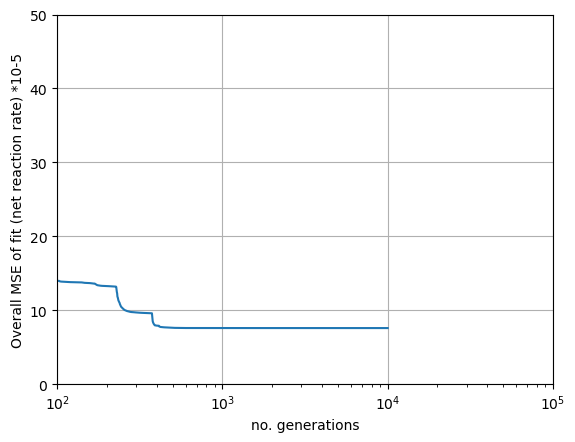

In [32]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [33]:
for i in range(len (res.X)):
    print (res.X[i])

0.9327284663689509
8.433599493509405
8.432762264968312
0.6007305113472592
7.727199853948098
7.731902222809029
7.798562296922613
0.9314412774459119
6.944299385736765
7.0534403806518124
6.773744994352771
6.936417228264961
1.095328815755616
7.01617605210497
6.660034650016868
7.433936752686035
7.120962887633701
2.927874685476118
8.937694344334975
1.6374951459032538
8.650753566009362
8.659568657532954
8.638411858159955
7.640853040103963
0.4479157894448873
6.455218785565893
2.1098537041162713
5.113033688102467
7.116201716194059
7.115188832627466
1.9615316958107345
8.96400517826838
-1.3010299999999995
0.2304181011847426


In [34]:
res.X

array([ 0.93272847,  8.43359949,  8.43276226,  0.60073051,  7.72719985,
        7.73190222,  7.7985623 ,  0.93144128,  6.94429939,  7.05344038,
        6.77374499,  6.93641723,  1.09532882,  7.01617605,  6.66003465,
        7.43393675,  7.12096289,  2.92787469,  8.93769434,  1.63749515,
        8.65075357,  8.65956866,  8.63841186,  7.64085304,  0.44791579,
        6.45521879,  2.1098537 ,  5.11303369,  7.11620172,  7.11518883,
        1.9615317 ,  8.96400518, -1.30103   ,  0.2304181 ])

In [35]:
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3
    
import numpy as np
logkr=np.log10(kr)
logkr

array([1. , 8.5, 8.5, 2. , 9. , 9. , 9. , 2. , 8. , 8. , 8. , 8. , 2. ,
       8. , 8. , 8. , 8. , 2. , 8. , 1. , 8. , 8. , 8. , 7. , 1. , 7. ,
       3. , 6. , 8. , 8. , 1. , 8. , 0.1])

In [36]:
for i in range(len (logkr)):
    print (logkr[i])

1.0
8.5
8.5
2.0
9.0
9.0
9.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
1.0
8.0
8.0
8.0
7.0
1.0
7.0
3.0
6.0
8.0
8.0
1.0
8.0
0.10000000000000002


In [37]:
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-2]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

1.0: 0.9327284663689509
8.5: 8.433599493509405
8.5: 8.432762264968312
2.0: 0.6007305113472592
9.0: 7.727199853948098
9.0: 7.731902222809029
9.0: 7.798562296922613
2.0: 0.9314412774459119
8.0: 6.944299385736765
8.0: 7.0534403806518124
8.0: 6.773744994352771
8.0: 6.936417228264961
2.0: 1.095328815755616
8.0: 7.01617605210497
8.0: 6.660034650016868
8.0: 7.433936752686035
8.0: 7.120962887633701
2.0: 2.927874685476118
8.0: 8.937694344334975
1.0: 1.6374951459032538
8.0: 8.650753566009362
8.0: 8.659568657532954
8.0: 8.638411858159955
7.0: 7.640853040103963
1.0: 0.4479157894448873
7.0: 6.455218785565893
3.0: 2.1098537041162713
6.0: 5.113033688102467
8.0: 7.116201716194059
8.0: 7.115188832627466
1.0: 1.9615316958107345
8.0: 8.96400517826838
0.10000000000000002: 0.2304181011847426
coeff fit: 0.9141728814851495
r: 0.9561238839633437
